### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from jasmine.investigator.statistical_functions import creating_statistics_table
from jasmine.investigator.statistical_plots import cumulative_distribution_presentation_plotter, histogram_presentation_plotter

# The representative sample: 2371 events



In [2]:
lightcurve_type_ = 'sample_rtmodel_v2.4'
q_and_s_24_summary_df = pd.read_csv(f'/Users/stela/Documents/Scripts/orbital_task/RTModel_runs/{lightcurve_type_}/all_{lightcurve_type_}_q_s.csv', index_col=['event_name'])
parallax_24_summary_df =  pd.read_csv(f'/Users/stela/Documents/Scripts/orbital_task/RTModel_runs/{lightcurve_type_}/all_{lightcurve_type_}_parallax.csv', index_col=['event_name'])

representative_sample_df = pd.read_csv('/Users/stela/Documents/Scripts/orbital_task/data/gulls_orbital_motion_extracted/OMPLDG_croin_cassan.sample.csv')
representative_sample_df['event_name'] = 'event_' + representative_sample_df['SubRun'].astype(str) + '_' + representative_sample_df['Field'].astype(str) + '_' + representative_sample_df['EventID'].astype(str)

| **Label** | **Model**                                               | **Number of parameters** |
|:---------:|:-------------------------------------------------------:|:------------------------:|
| LS        | Binary-lens-single-source                               | 7                        |
| LX        | Binary-lens-single-source with parallax                 | 9                        |
| LO        | Binary-lens-single-source with circular orbital motion  | 12                       |

### SAMPLE chi2 cut and other simple cuts

In [3]:
chi2_cut = 500
sample_df_chi2_filtered = representative_sample_df[representative_sample_df['ObsGroup_0_chi2'] > chi2_cut].copy()
print(f'sample ', representative_sample_df.shape)
print(f'sample_filtered for chi2: {chi2_cut}', sample_df_chi2_filtered.shape)

# Lens mass = [0.2, 0.5] and Lens distance = [1.0, 5.0]
lens_mass_and_distance_cut_df = pd.read_csv('/Users/stela/Documents/Scripts/orbital_task/data/gulls_orbital_motion_extracted/most_common_by_lens_mass_distance.csv')
lens_mass_and_distance_cut_df['event_name'] = 'event_' + lens_mass_and_distance_cut_df['SubRun'].astype(str) + '_' + lens_mass_and_distance_cut_df['Field'].astype(str) + '_' + lens_mass_and_distance_cut_df['EventID'].astype(str)
lens_mass_and_distance_cut_df_filtered = lens_mass_and_distance_cut_df[lens_mass_and_distance_cut_df['ObsGroup_0_chi2'] > chi2_cut].copy()
print(f'lens_mass_and_distance_cut:', lens_mass_and_distance_cut_df.shape)
print(f'lens_mass_and_distance_cut_filtered for chi2: {chi2_cut}', lens_mass_and_distance_cut_df_filtered.shape)

six_fields_df = pd.read_csv('/Users/stela/Documents/Scripts/orbital_task/data/gulls_orbital_motion_extracted/covfac_sample.csv')
six_fields_df = six_fields_df[six_fields_df['covfac6f_nogc'] != 0]
six_fields_df['event_name'] = 'event_' + six_fields_df['SubRun'].astype(str) + '_' + six_fields_df['Field'].astype(str) + '_' + six_fields_df['EventID'].astype(str)
six_fields_df_filtered = six_fields_df[six_fields_df['ObsGroup_0_chi2'] > chi2_cut].copy()
print(f'six_fields:', six_fields_df.shape)
print(f'six_fields_filtered for chi2: {chi2_cut}', six_fields_df_filtered.shape)

six_fields_lens_mass_and_distance_cut_df = six_fields_df.merge(lens_mass_and_distance_cut_df)
six_fields_lens_mass_and_distance_cut_df_filtered = six_fields_df_filtered.merge(lens_mass_and_distance_cut_df_filtered)
print(f'six_fields_lens_mass_and_distance_cut:', six_fields_lens_mass_and_distance_cut_df.shape)
print(f'six_fields_lens_mass_and_distance_cut_filtered for chi2: {chi2_cut}', six_fields_lens_mass_and_distance_cut_df_filtered.shape)


sample  (2371, 200)
sample_filtered for chi2: 500 (1358, 200)
most_common: (39, 200)
most_common_filtered for chi2: 500 (25, 200)
six_fields: (1065, 206)
six_fields_filtered for chi2: 500 (622, 206)
six_fields_most_common: (18, 206)
six_fields_most_common_filtered for chi2: 500 (11, 206)


# Preparing data of interest


In [4]:
# WORKING DATA
# Preparing columns of interest
columns_to_copy = ['event_name','piE', 'piEE', 'piEN', 'final_weight']
working_data = representative_sample_df[columns_to_copy].copy()
working_data = creating_statistics_table(working_data, parallax_24_summary_df, is_save_=False) # you can create or just read file "rtmodelv2.4_statistics.csv"

In [5]:
# THE WORKING DATA DATAFRAMES FILTERED FOR INTEREST
working_data_filtered = working_data.loc[sample_df_chi2_filtered['event_name']].copy()
working_data_lens_mass_and_distance_cut = working_data.loc[lens_mass_and_distance_cut_df['event_name']].copy()
working_data_lens_mass_and_distance_cut_filtered = working_data.loc[lens_mass_and_distance_cut_df_filtered['event_name']].copy()
working_data_six_fields = working_data.loc[six_fields_df['event_name']].copy()
working_data_six_fields_filtered = working_data.loc[six_fields_df_filtered['event_name']].copy()
working_data_six_fields_lens_mass_and_distance_cut = working_data.loc[six_fields_lens_mass_and_distance_cut_df['event_name']].copy()
working_data_six_fields_lens_mass_and_distance_cut_filtered = working_data.loc[six_fields_lens_mass_and_distance_cut_df_filtered['event_name']].copy()

# Other formulas

In [6]:
def cuts_event_numbers(working_data_dataframe, piE_type, precision_cut):
    print(f'for type of piE: {piE_type}')
    working_data_cut_LX = working_data_dataframe[working_data_dataframe[f'LX_{piE_type}_absolute_predicted_error_predicted_value_ratio'] < precision_cut].copy()
    working_data_cut_LO = working_data_dataframe[working_data_dataframe[f'LO_{piE_type}_absolute_predicted_error_predicted_value_ratio'] < precision_cut].copy()
    common_events = np.intersect1d(np.array(working_data_cut_LX.index), np.array(working_data_cut_LO.index))

    # Find unique event names in each DataFrame
    unique_LX = np.setdiff1d(np.array(working_data_cut_LX.index), np.array(working_data_cut_LO.index))
    unique_LO = np.setdiff1d(np.array(working_data_cut_LO.index), np.array(working_data_cut_LX.index))

    # Print the shape of DataFrames
    print(f"Shape of working_data_10_LX: {working_data_cut_LX.shape}")  # (rows, columns)
    print(f"Shape of working_data_10_LO: {working_data_cut_LO.shape}")  # (rows, columns)

    # Print results
    print(f"Number of common events: {common_events.size}")
    print(f"Number of unique events in LX: {unique_LX.size}")
    print(f"Number of unique events in LO: {unique_LO.size}")

In [7]:
def cuts_event_numbers_weighted(working_data_dataframe, piE_type, precision_cut):
    print(f'For type of piE: {piE_type}')

    # Compute percentage weight for each event (normalized to 100)
    working_data_dataframe = working_data_dataframe.copy()  # Avoid modifying the original DF
    working_data_dataframe['stela_weight'] = (working_data_dataframe['final_weight'] /
                                              working_data_dataframe['final_weight'].sum()) * 100

    # Apply precision cut for LX and LO
    working_data_cut_LX = working_data_dataframe[
        working_data_dataframe[f'LX_{piE_type}_absolute_predicted_error_predicted_value_ratio'] < precision_cut
    ].copy()

    working_data_cut_LO = working_data_dataframe[
        working_data_dataframe[f'LO_{piE_type}_absolute_predicted_error_predicted_value_ratio'] < precision_cut
    ].copy()

    print(f"LX percentage: {working_data_cut_LX['stela_weight'].sum()}%")
    print(f"LO percentage: {working_data_cut_LO['stela_weight'].sum()}%")

    # Get event indices as NumPy arrays
    index_LX = np.array(working_data_cut_LX.index)
    index_LO = np.array(working_data_cut_LO.index)

    # Find common and unique events
    common_events = np.intersect1d(index_LX, index_LO)
    unique_LX = np.setdiff1d(index_LX, index_LO)
    unique_LO = np.setdiff1d(index_LO, index_LX)

    # Compute summed stela_weight for each category
    weight_common = working_data_dataframe.loc[common_events, 'stela_weight'].sum()
    print(f"Common events: {weight_common:}%")
    weight_LX = working_data_dataframe.loc[unique_LX, 'stela_weight'].sum()
    print(f"Unique events LX: {weight_LX:}%")
    weight_LO = working_data_dataframe.loc[unique_LO, 'stela_weight'].sum()
    print(f"Unique events LO: {weight_LO:}%")

    # Print total percentage check
    total_percentage = working_data_dataframe['stela_weight'].sum()
    print(f"Total stela_weight sum (should be ~100%): {total_percentage:.2f}%")


# Summary of the results

## Representative Sample

### piE

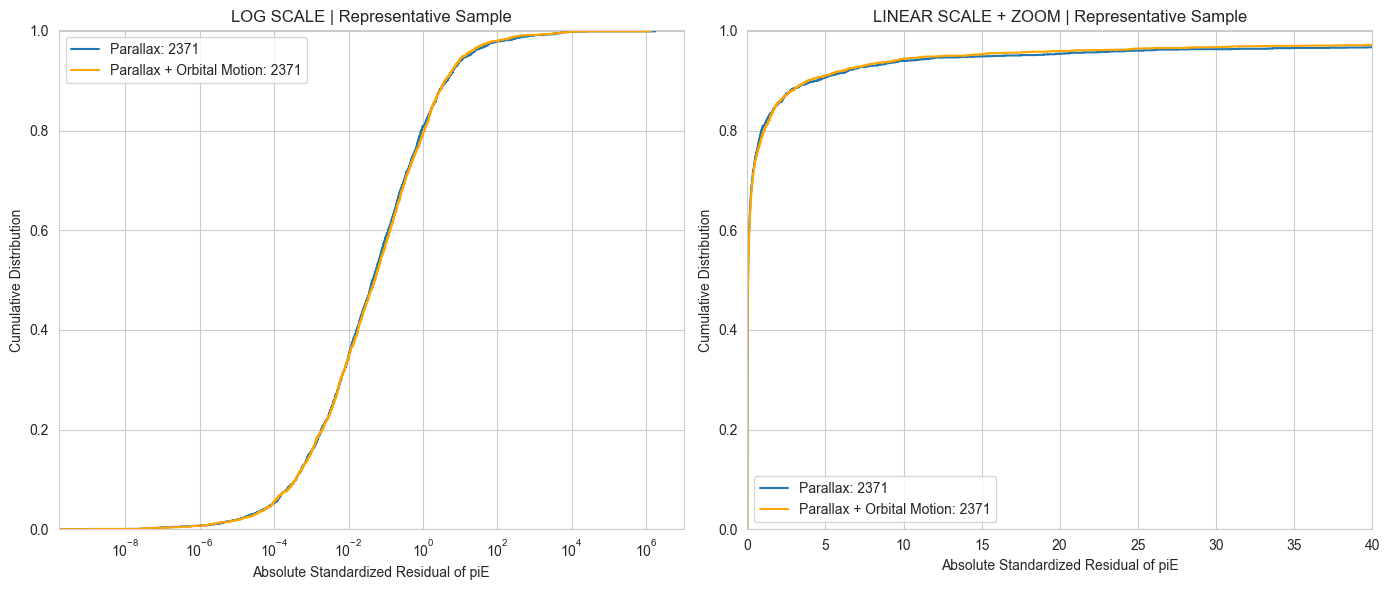

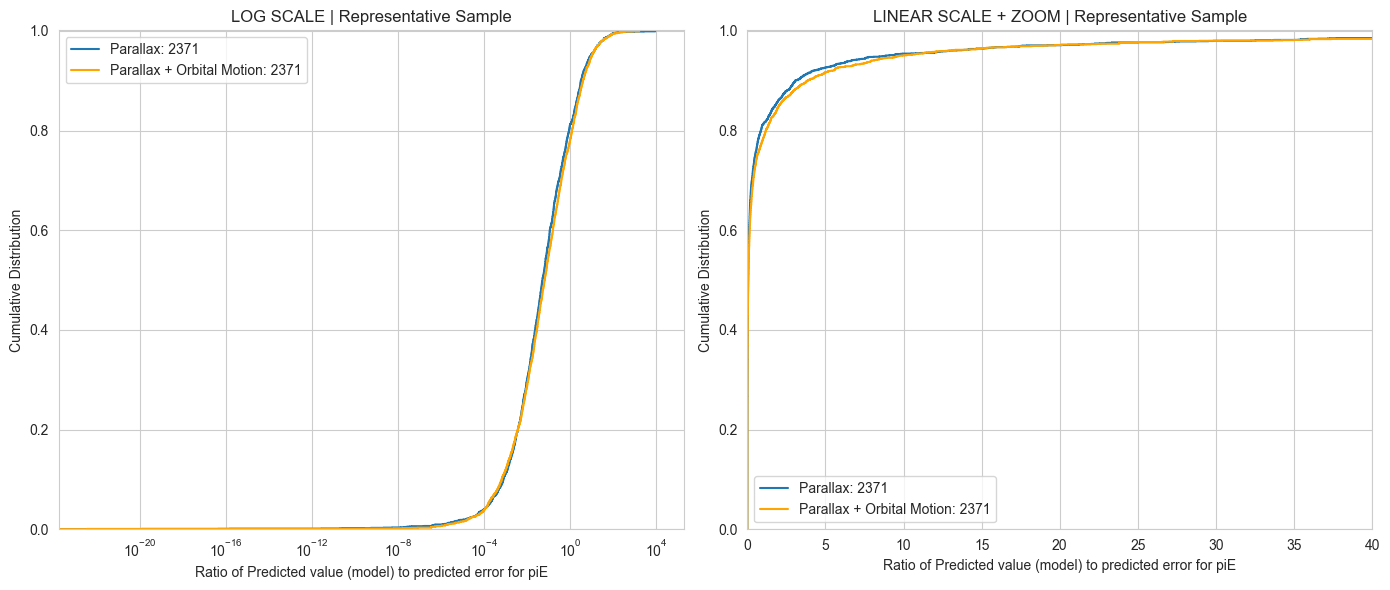

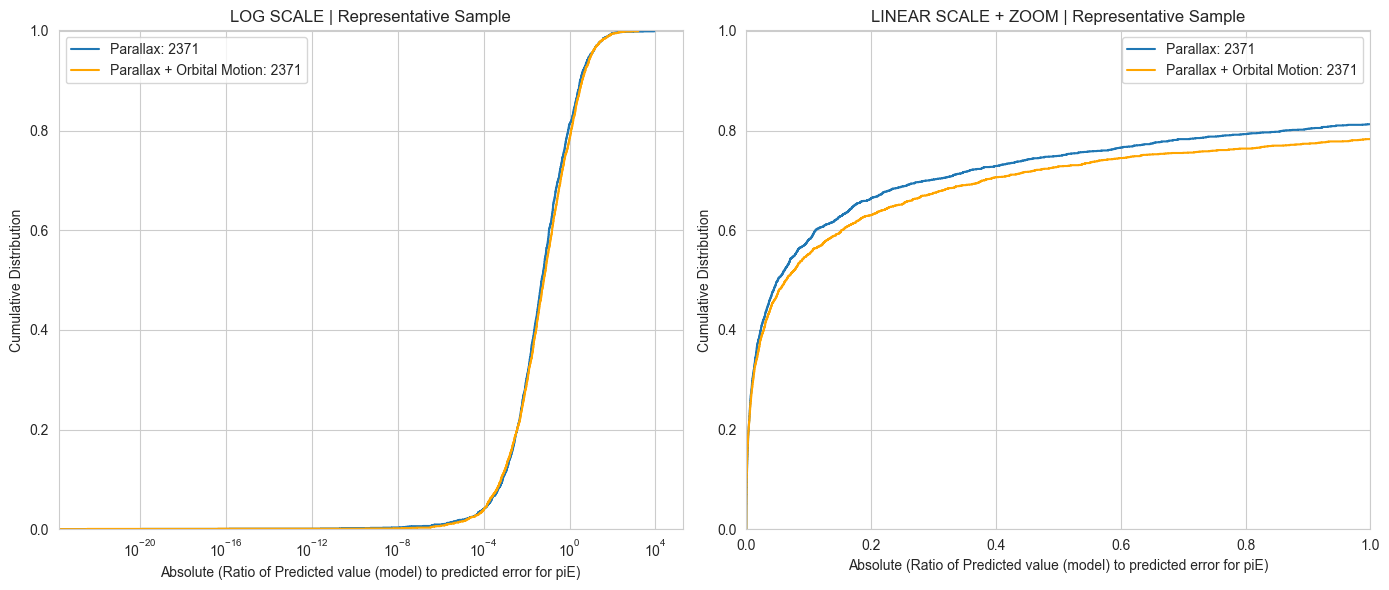

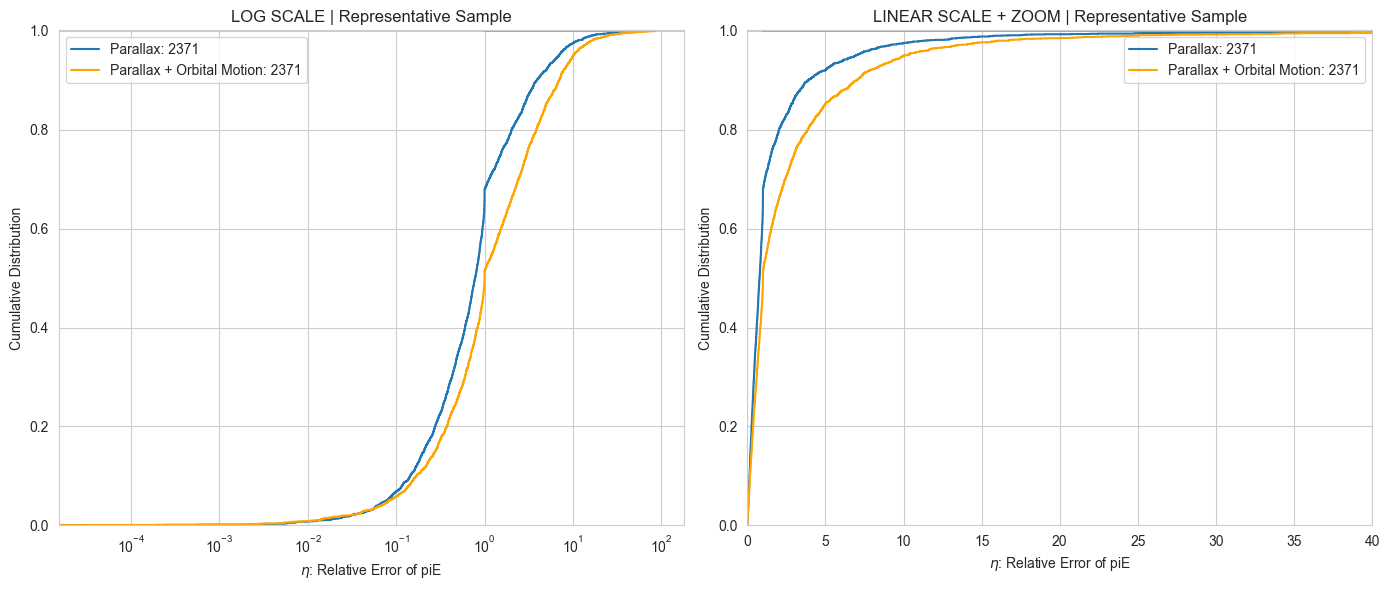

In [8]:
piE_type = 'piE'
cumulative_distribution_presentation_plotter(working_data, f'LX_{piE_type}_absolute_standardized_residual', f'LO_{piE_type}_absolute_standardized_residual',
                                title='Representative Sample', what_you_plotting=f'Absolute Standardized Residual of {piE_type}')
cumulative_distribution_presentation_plotter(working_data, f'LX_{piE_type}_predicted_value_predicted_error_ratio', f'LO_{piE_type}_predicted_value_predicted_error_ratio',
                                title='Representative Sample', what_you_plotting=f'Ratio of Predicted value (model) to predicted error for {piE_type}')
cumulative_distribution_presentation_plotter(working_data, f'LX_{piE_type}_absolute_predicted_value_predicted_error_ratio', f'LO_{piE_type}_absolute_predicted_value_predicted_error_ratio',
                                title='Representative Sample', what_you_plotting=f'Absolute (Ratio of Predicted value (model) to predicted error for {piE_type})', xmax_linear=1)
cumulative_distribution_presentation_plotter(working_data, f'LX_{piE_type}_relative_error', f'LO_{piE_type}_relative_error',
                                title='Representative Sample', what_you_plotting=fr'$\eta$: Relative Error of {piE_type}')

### piEE

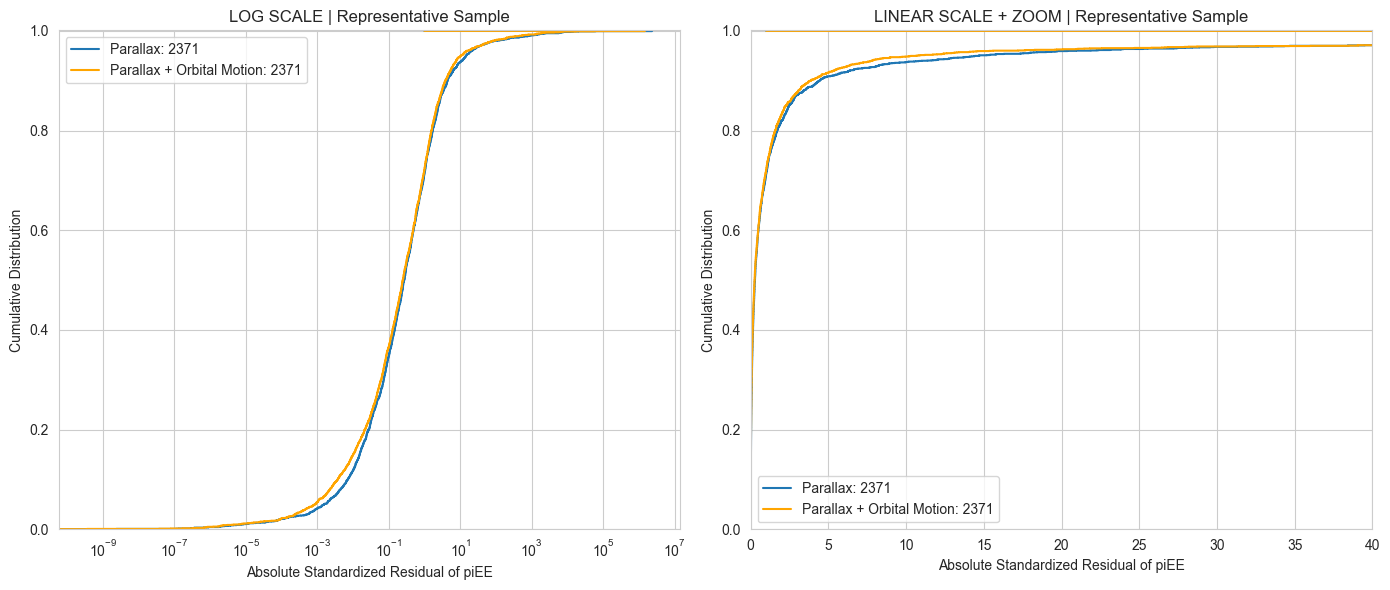

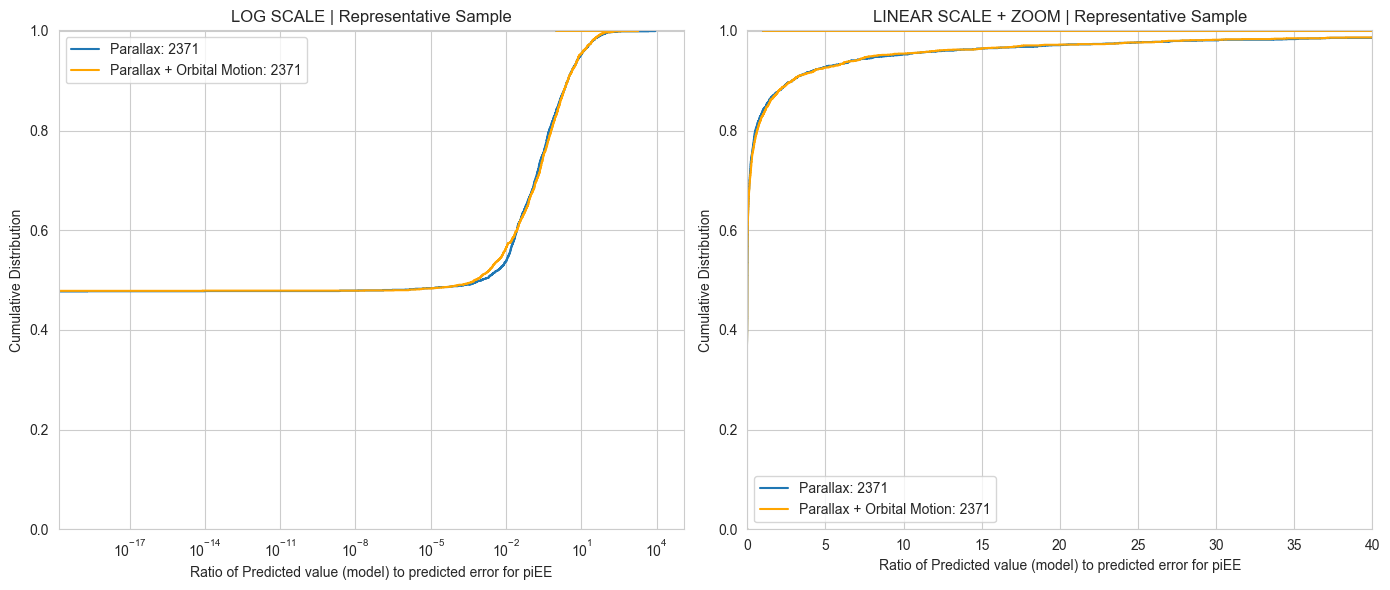

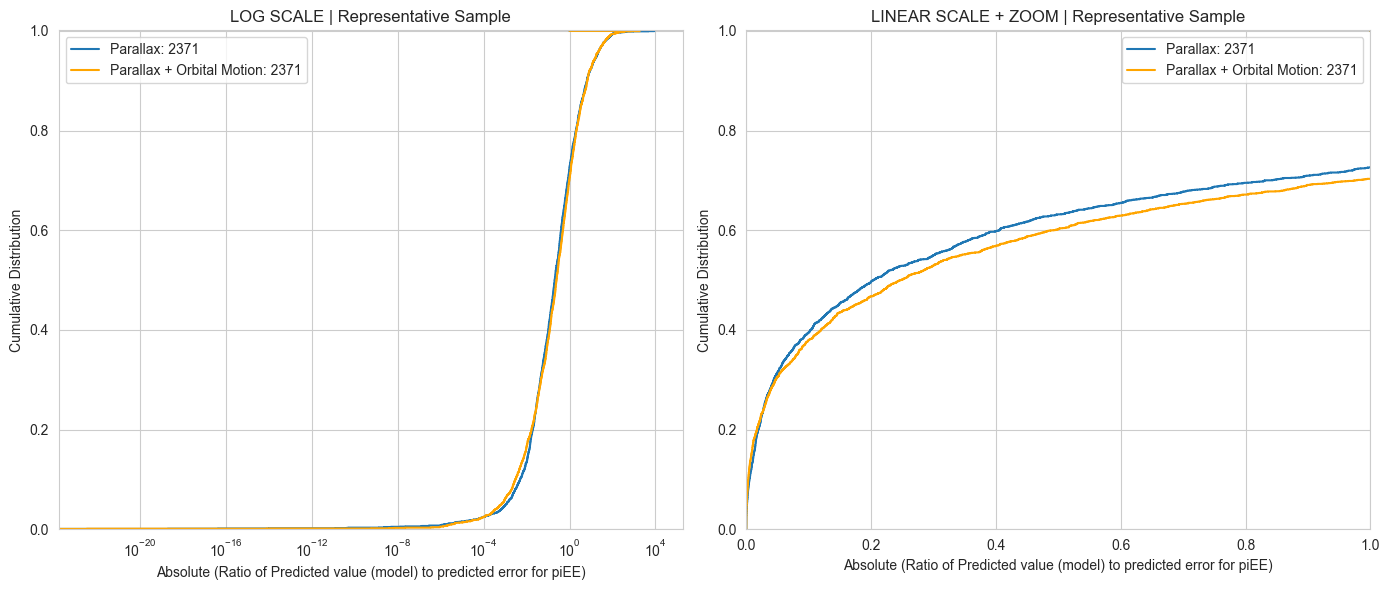

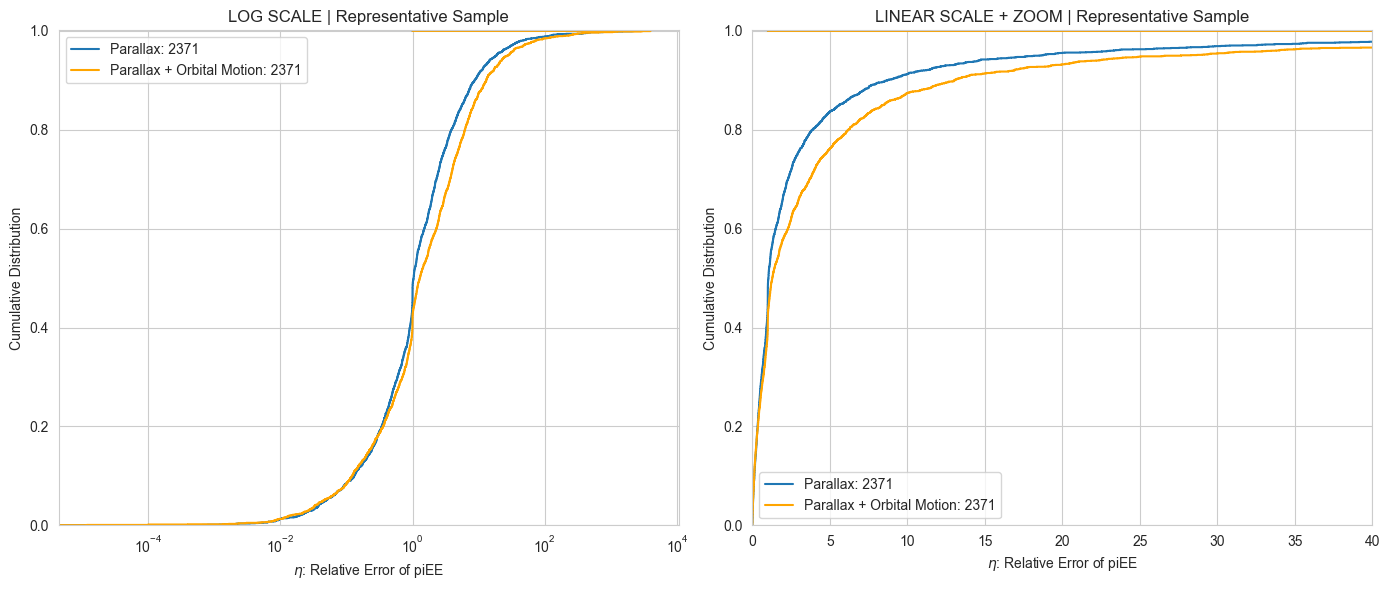

In [9]:
piE_type = 'piEE'
cumulative_distribution_presentation_plotter(working_data, f'LX_{piE_type}_absolute_standardized_residual', f'LO_{piE_type}_absolute_standardized_residual',
                                title='Representative Sample', what_you_plotting=f'Absolute Standardized Residual of {piE_type}')
cumulative_distribution_presentation_plotter(working_data, f'LX_{piE_type}_predicted_value_predicted_error_ratio', f'LO_{piE_type}_predicted_value_predicted_error_ratio',
                                title='Representative Sample', what_you_plotting=f'Ratio of Predicted value (model) to predicted error for {piE_type}')
cumulative_distribution_presentation_plotter(working_data, f'LX_{piE_type}_absolute_predicted_value_predicted_error_ratio', f'LO_{piE_type}_absolute_predicted_value_predicted_error_ratio',
                                title='Representative Sample', what_you_plotting=f'Absolute (Ratio of Predicted value (model) to predicted error for {piE_type})', xmax_linear=1)
cumulative_distribution_presentation_plotter(working_data, f'LX_{piE_type}_relative_error', f'LO_{piE_type}_relative_error',
                                title='Representative Sample', what_you_plotting=fr'$\eta$: Relative Error of {piE_type}')

### piEN

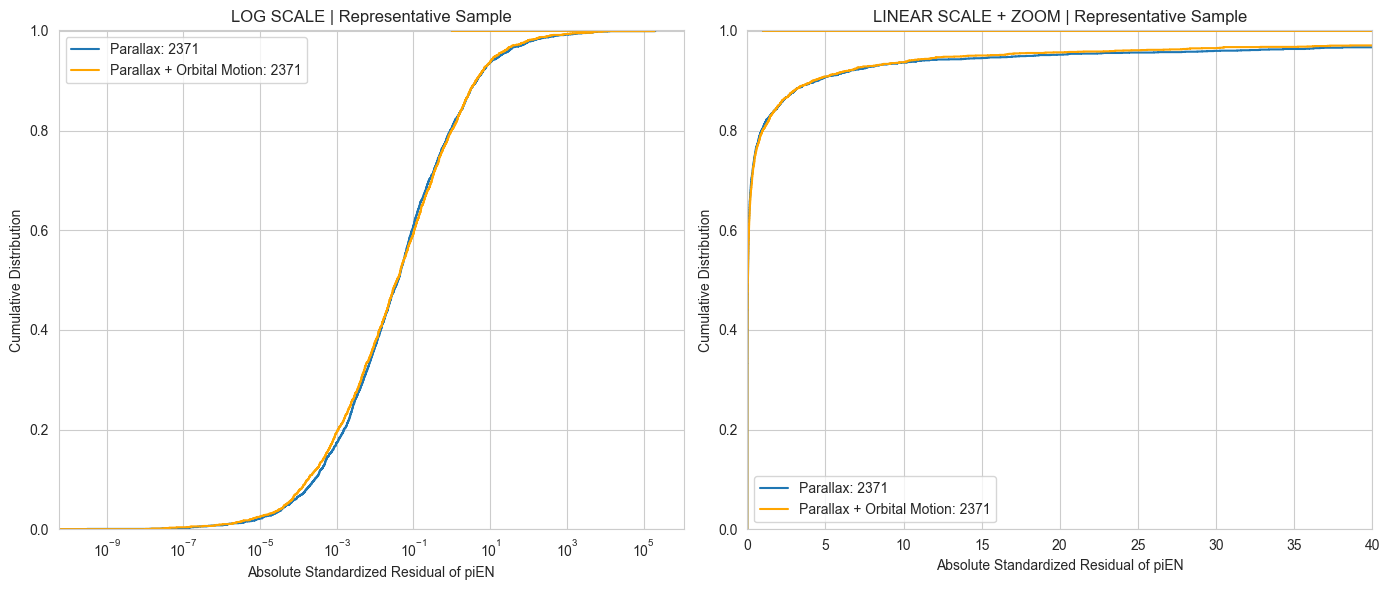

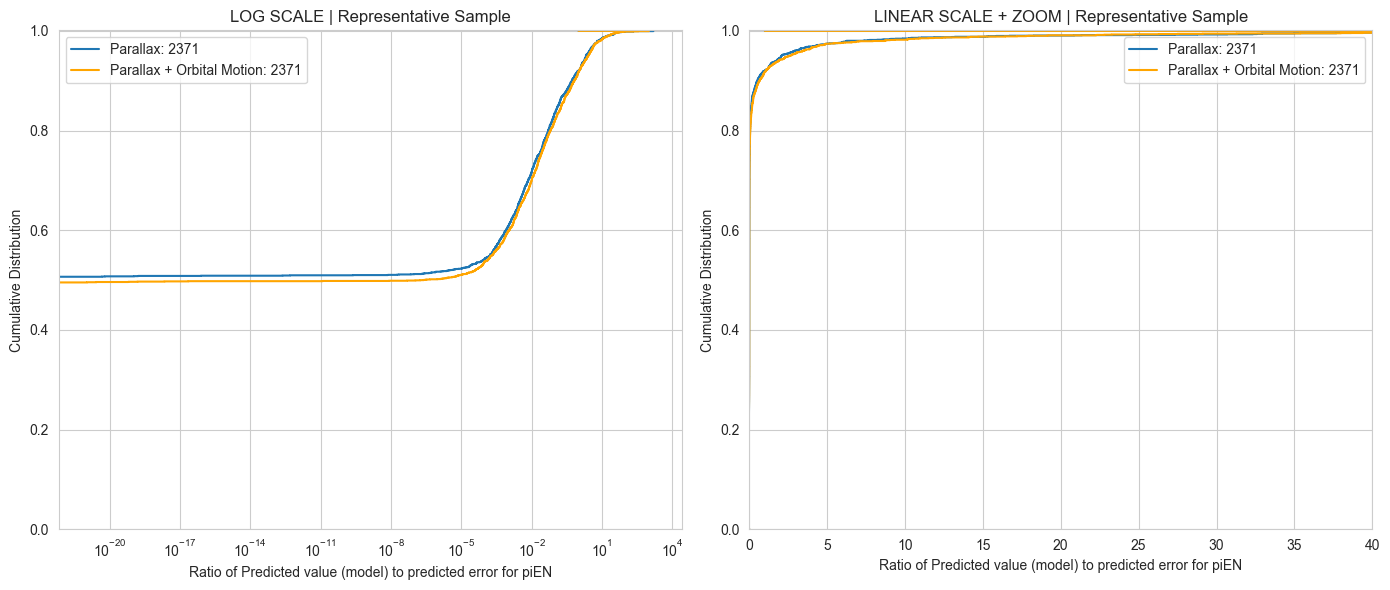

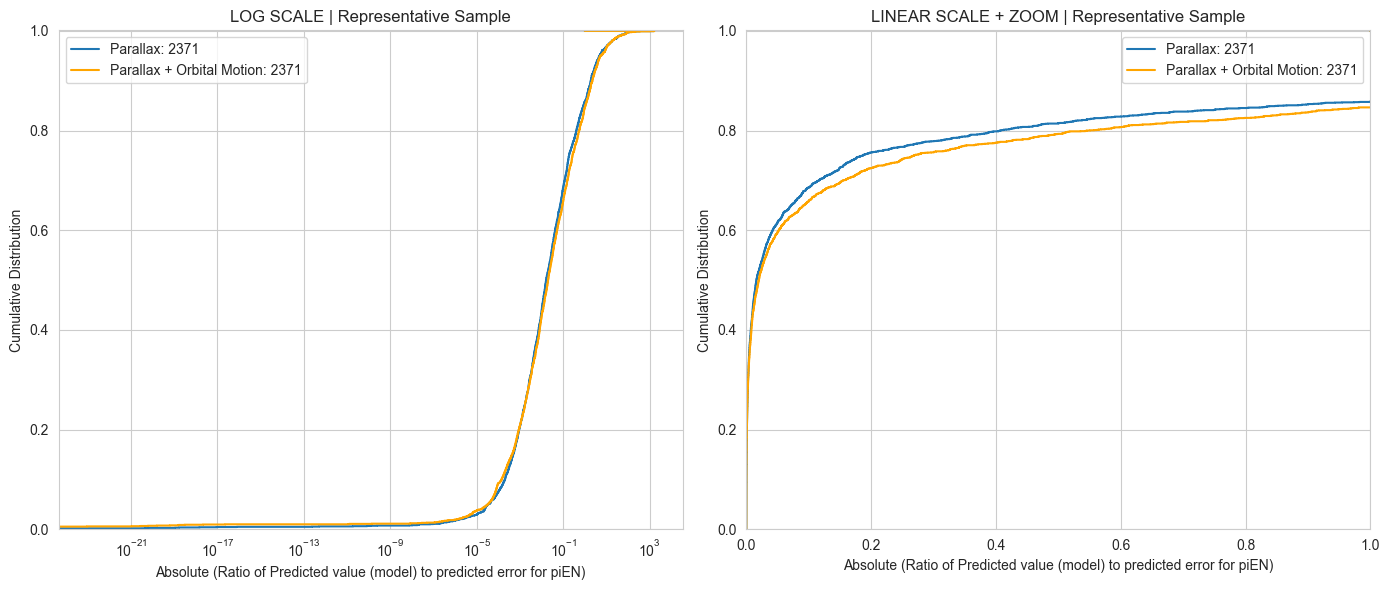

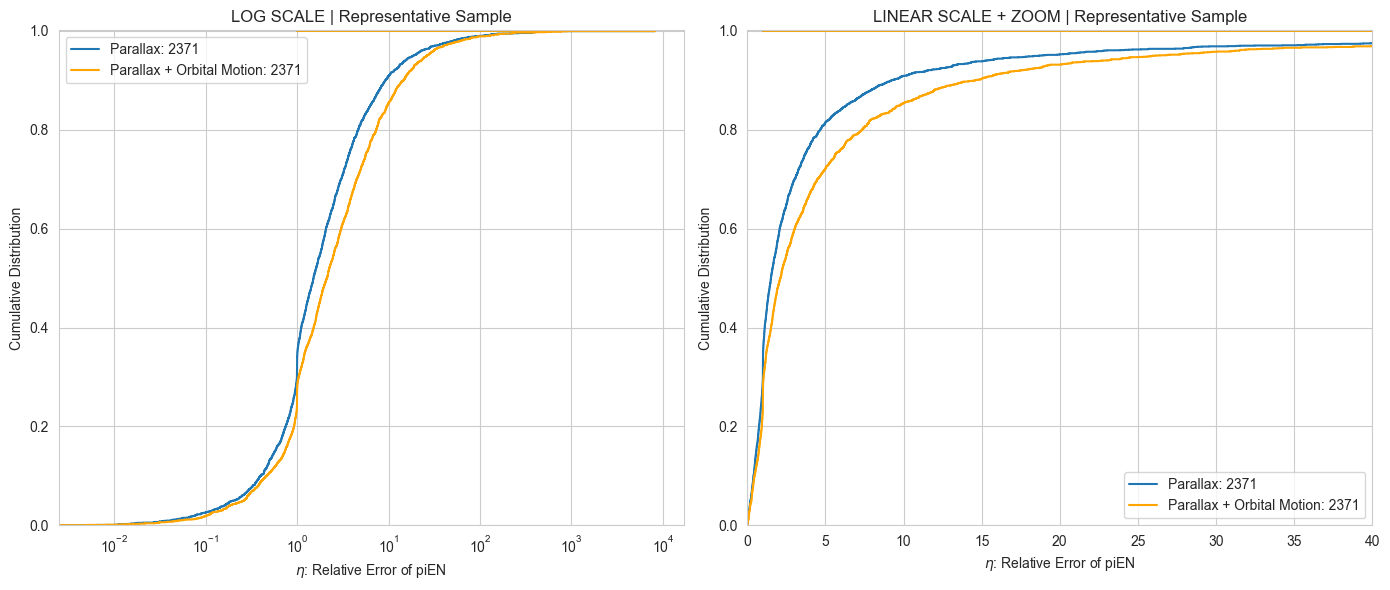

In [10]:
piE_type = 'piEN'
cumulative_distribution_presentation_plotter(working_data, f'LX_{piE_type}_absolute_standardized_residual', f'LO_{piE_type}_absolute_standardized_residual',
                                title='Representative Sample', what_you_plotting=f'Absolute Standardized Residual of {piE_type}')
cumulative_distribution_presentation_plotter(working_data, f'LX_{piE_type}_predicted_value_predicted_error_ratio', f'LO_{piE_type}_predicted_value_predicted_error_ratio',
                                title='Representative Sample', what_you_plotting=f'Ratio of Predicted value (model) to predicted error for {piE_type}')
cumulative_distribution_presentation_plotter(working_data, f'LX_{piE_type}_absolute_predicted_value_predicted_error_ratio', f'LO_{piE_type}_absolute_predicted_value_predicted_error_ratio',
                                title='Representative Sample', what_you_plotting=f'Absolute (Ratio of Predicted value (model) to predicted error for {piE_type})', xmax_linear=1)
cumulative_distribution_presentation_plotter(working_data, f'LX_{piE_type}_relative_error', f'LO_{piE_type}_relative_error',
                                title='Representative Sample', what_you_plotting=fr'$\eta$: Relative Error of {piE_type}')

## Error / Value investigation

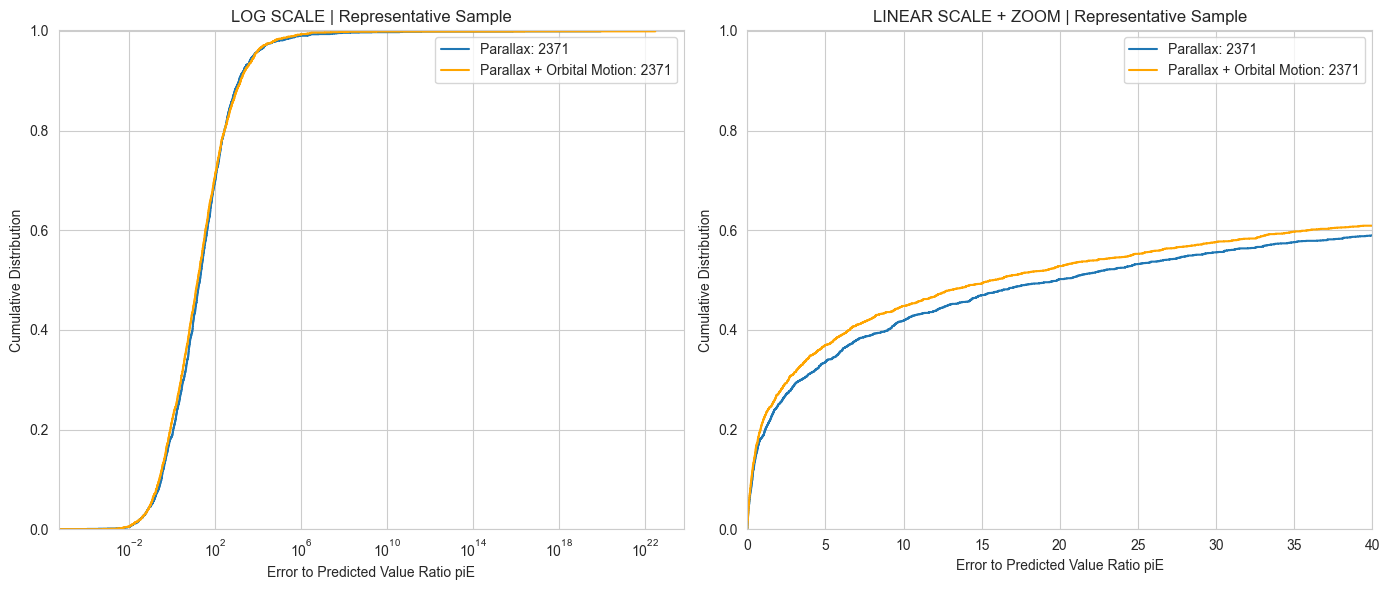

In [11]:
piE_type = 'piE'

cumulative_distribution_presentation_plotter(working_data, f'LX_{piE_type}_predicted_error_predicted_value_ratio', f'LO_{piE_type}_predicted_error_predicted_value_ratio',
                                title='Representative Sample', what_you_plotting=f'Error to Predicted Value Ratio {piE_type}')

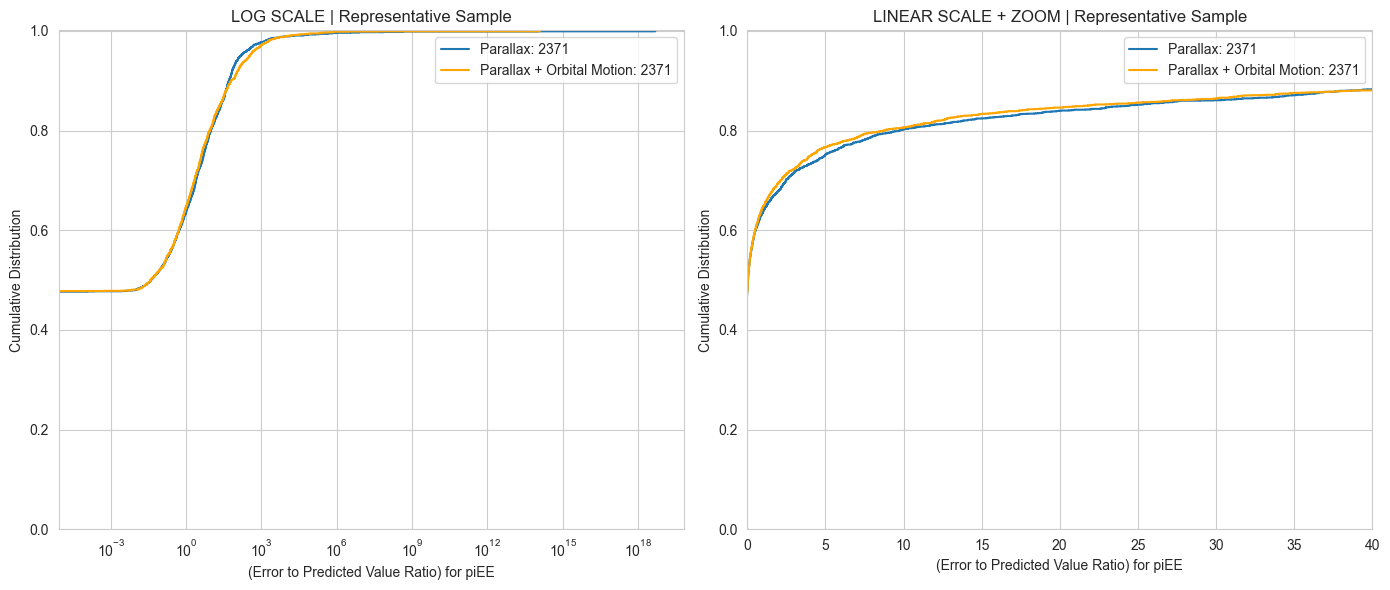

In [12]:
piE_type = 'piEE'

cumulative_distribution_presentation_plotter(working_data, f'LX_{piE_type}_predicted_error_predicted_value_ratio', f'LO_{piE_type}_predicted_error_predicted_value_ratio',
                                title='Representative Sample', what_you_plotting=f'(Error to Predicted Value Ratio) for {piE_type}')

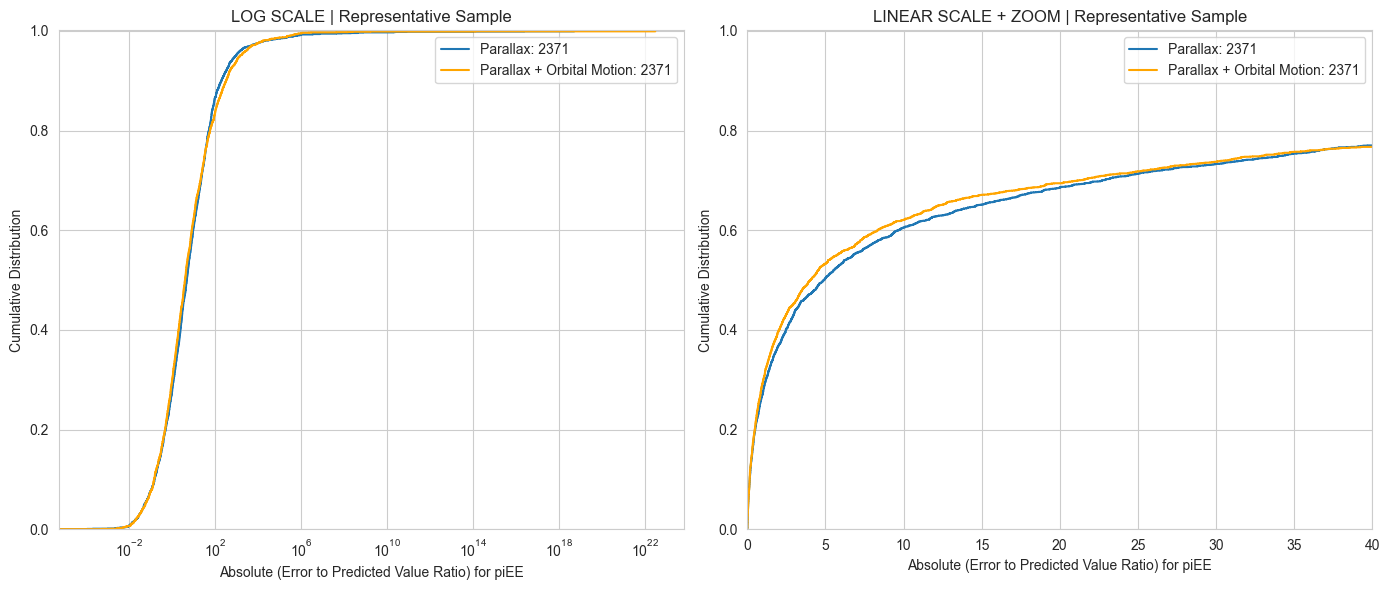

In [13]:
piE_type = 'piEE'

cumulative_distribution_presentation_plotter(working_data, f'LX_{piE_type}_absolute_predicted_error_predicted_value_ratio', f'LO_{piE_type}_absolute_predicted_error_predicted_value_ratio',
                                title='Representative Sample', what_you_plotting=f'Absolute (Error to Predicted Value Ratio) for {piE_type}')

## Histograms

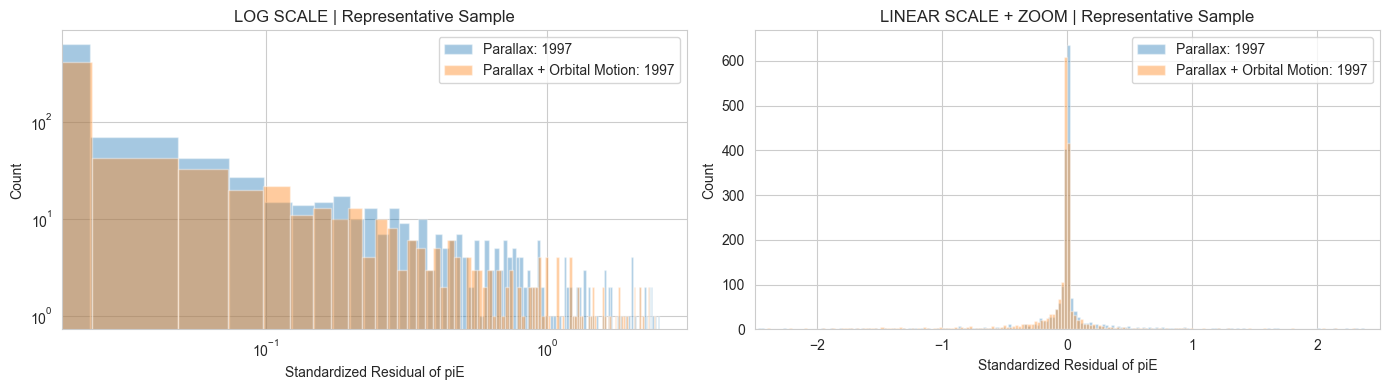

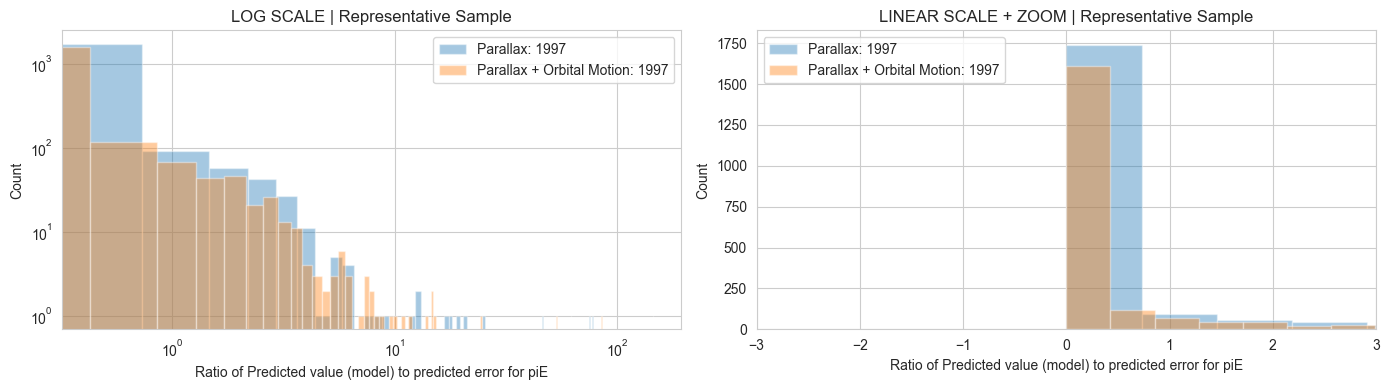

In [14]:
piE_type = 'piE'
# working_data_dropped = working_data_.query("event_name != 'event_0_922_1199'")
working_data_dropped = working_data.loc[working_data[f'LX_{piE_type}_standardized_residual'] < 2.5]
working_data_dropped = working_data_dropped.loc[working_data_dropped[f'LX_{piE_type}_standardized_residual'] > -2.5]
working_data_dropped = working_data_dropped.loc[working_data_dropped[f'LO_{piE_type}_standardized_residual'] < 2.5]
working_data_dropped = working_data_dropped.loc[working_data_dropped[f'LO_{piE_type}_standardized_residual'] > -2.5]


histogram_presentation_plotter(working_data_dropped, f'LX_{piE_type}_standardized_residual', f'LO_{piE_type}_standardized_residual',
                                title='Representative Sample', what_you_plotting=f'Standardized Residual of {piE_type}', bins=200,
                               xmax_linear=2.5)

histogram_presentation_plotter(working_data_dropped, f'LX_{piE_type}_predicted_value_predicted_error_ratio', f'LO_{piE_type}_predicted_value_predicted_error_ratio',
                                title='Representative Sample', what_you_plotting=f'Ratio of Predicted value (model) to predicted error for {piE_type}', bins=200,
                               xmax_linear=3)

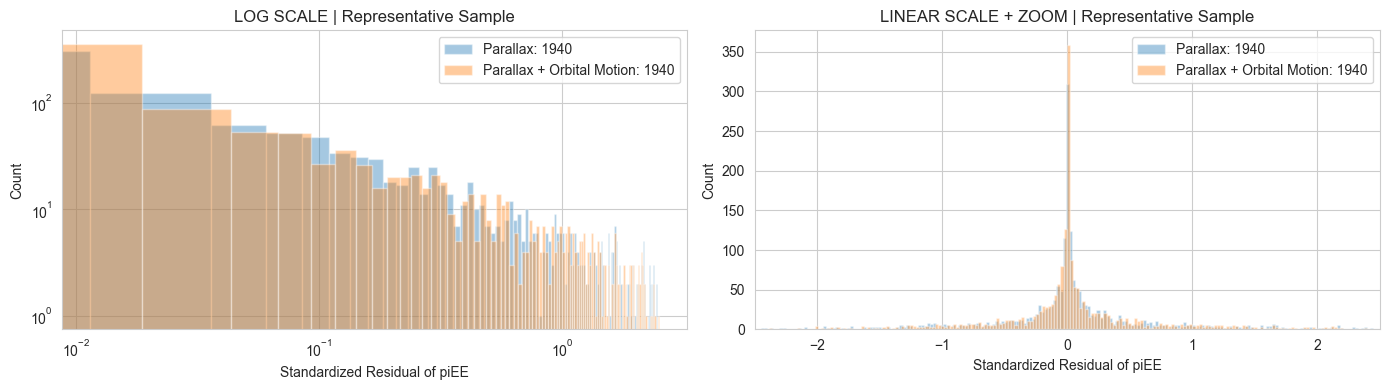

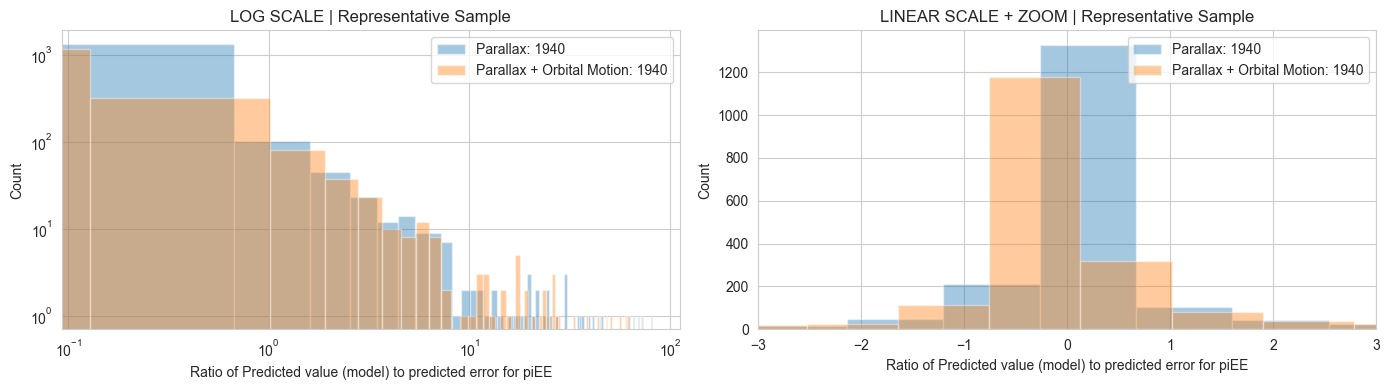

In [17]:
piE_type = 'piEE'
# working_data_dropped = working_data_.query("event_name != 'event_0_922_1199'")
working_data_dropped = working_data.loc[working_data[f'LX_{piE_type}_standardized_residual'] < 2.5]
working_data_dropped = working_data_dropped.loc[working_data_dropped[f'LX_{piE_type}_standardized_residual'] > -2.5]
working_data_dropped = working_data_dropped.loc[working_data_dropped[f'LO_{piE_type}_standardized_residual'] < 2.5]
working_data_dropped = working_data_dropped.loc[working_data_dropped[f'LO_{piE_type}_standardized_residual'] > -2.5]


histogram_presentation_plotter(working_data_dropped, f'LX_{piE_type}_standardized_residual', f'LO_{piE_type}_standardized_residual',
                                title='Representative Sample', what_you_plotting=f'Standardized Residual of {piE_type}', bins=200,
                               xmax_linear=2.5)

histogram_presentation_plotter(working_data_dropped, f'LX_{piE_type}_predicted_value_predicted_error_ratio', f'LO_{piE_type}_predicted_value_predicted_error_ratio',
                                title='Representative Sample', what_you_plotting=f'Ratio of Predicted value (model) to predicted error for {piE_type}', bins=200,
                               xmax_linear=3)

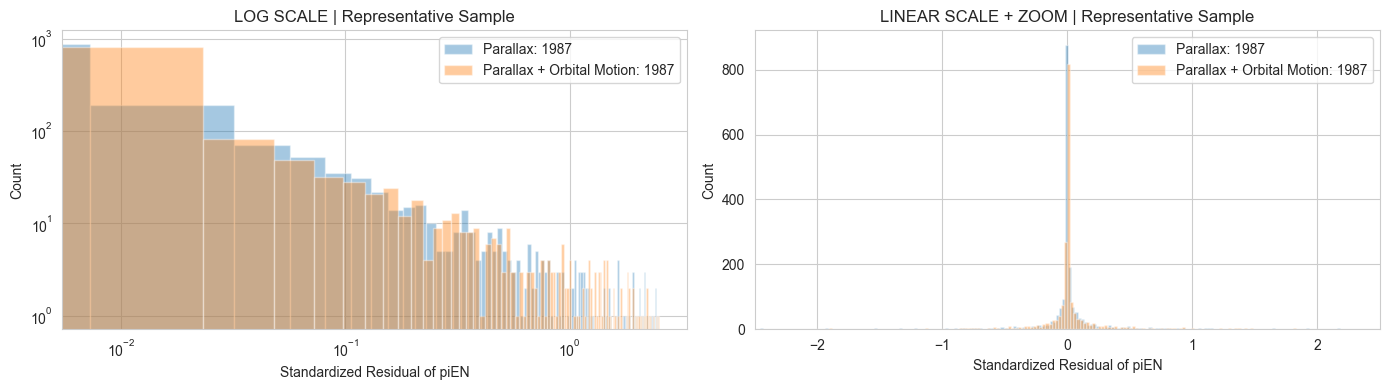

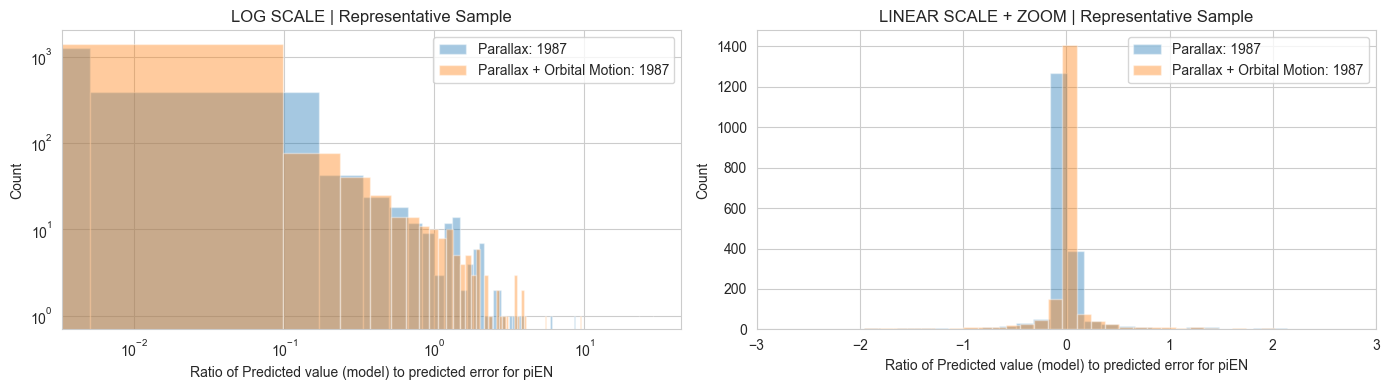

In [18]:
piE_type = 'piEN'
# working_data_dropped = working_data_.query("event_name != 'event_0_922_1199'")
working_data_dropped = working_data.loc[working_data[f'LX_{piE_type}_standardized_residual'] < 2.5]
working_data_dropped = working_data_dropped.loc[working_data_dropped[f'LX_{piE_type}_standardized_residual'] > -2.5]
working_data_dropped = working_data_dropped.loc[working_data_dropped[f'LO_{piE_type}_standardized_residual'] < 2.5]
working_data_dropped = working_data_dropped.loc[working_data_dropped[f'LO_{piE_type}_standardized_residual'] > -2.5]


histogram_presentation_plotter(working_data_dropped, f'LX_{piE_type}_standardized_residual', f'LO_{piE_type}_standardized_residual',
                                title='Representative Sample', what_you_plotting=f'Standardized Residual of {piE_type}', bins=200,
                               xmax_linear=2.5)

histogram_presentation_plotter(working_data_dropped, f'LX_{piE_type}_predicted_value_predicted_error_ratio', f'LO_{piE_type}_predicted_value_predicted_error_ratio',
                                title='Representative Sample', what_you_plotting=f'Ratio of Predicted value (model) to predicted error for {piE_type}', bins=200,
                               xmax_linear=3)

# Representative Sample (or other sample with cuts) with Precision better than 10% (or other value you'd like to use)

$$\frac{\sigma_{\pi_E}}{\pi_E} < 0.1$$


In [46]:
cuts_event_numbers_weighted(working_data, 'piE', 0.1)

For type of piE: piE
LX percentage: 4.6667686892818825%
LO percentage: 4.887056501572903%
Common events: 3.3779625546540575%
Unique events LX: 1.2888061346278246%
Unique events LO: 1.5090939469188458%
Total stela_weight sum (should be ~100%): 100.00%


$$\frac{\sigma_{\pi_{EE}}}{\pi_{EE}} < 0.1$$

In [47]:
cuts_event_numbers_weighted(working_data, 'piEE', 0.1)

For type of piE: piEE
LX percentage: 7.71933961724088%
LO percentage: 8.435812119037127%
Common events: 6.934308200226749%
Unique events LX: 0.7850314170141313%
Unique events LO: 1.5015039188103776%
Total stela_weight sum (should be ~100%): 100.00%


$$\frac{\sigma_{\pi_{EN}}}{\pi_{EN}} < 0.1$$

In [48]:
cuts_event_numbers_weighted(working_data, 'piEN', 0.1)

For type of piE: piEN
LX percentage: 2.6119411058945197%
LO percentage: 2.8800314808610517%
Common events: 1.5805976474109362%
Unique events LX: 1.0313434584835834%
Unique events LO: 1.2994338334501156%
Total stela_weight sum (should be ~100%): 100.00%


## Plots with cuts

In [50]:
# PLOTTING CUTS
working_data_10_LX = working_data[working_data[f'LX_{piE_type}_absolute_predicted_error_predicted_value_ratio'] < 0.1]
working_data_10_LO = working_data[working_data[f'LO_{piE_type}_absolute_predicted_error_predicted_value_ratio'] < 0.1]

### piE

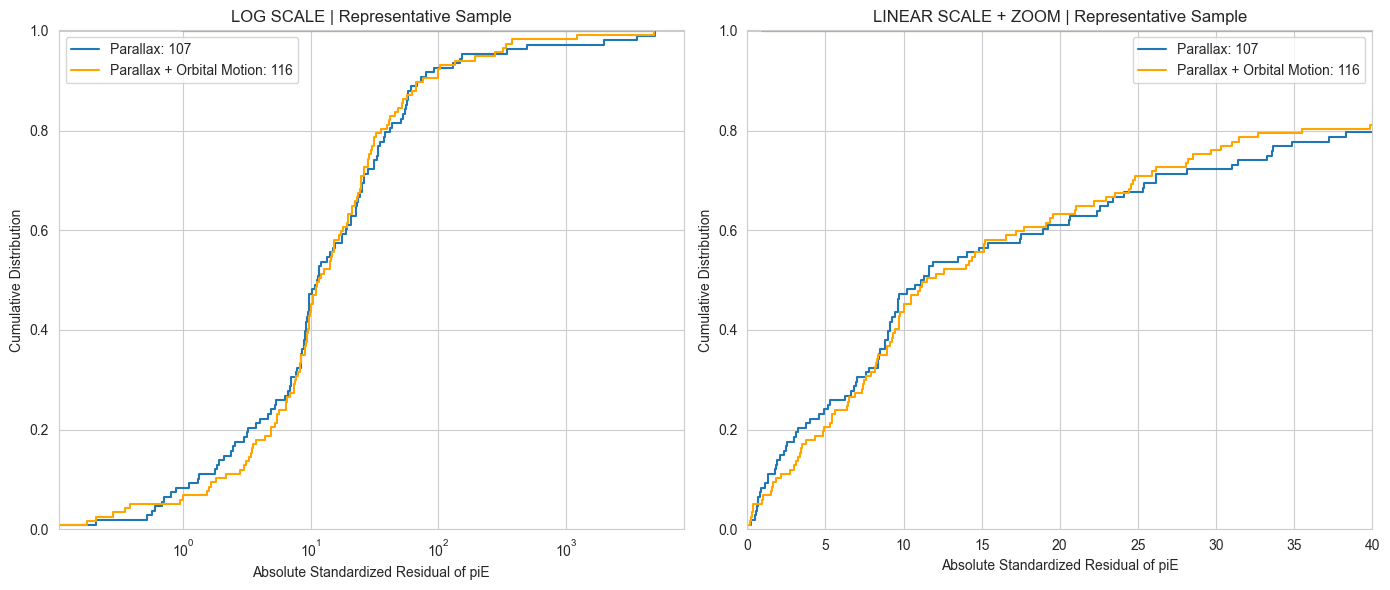

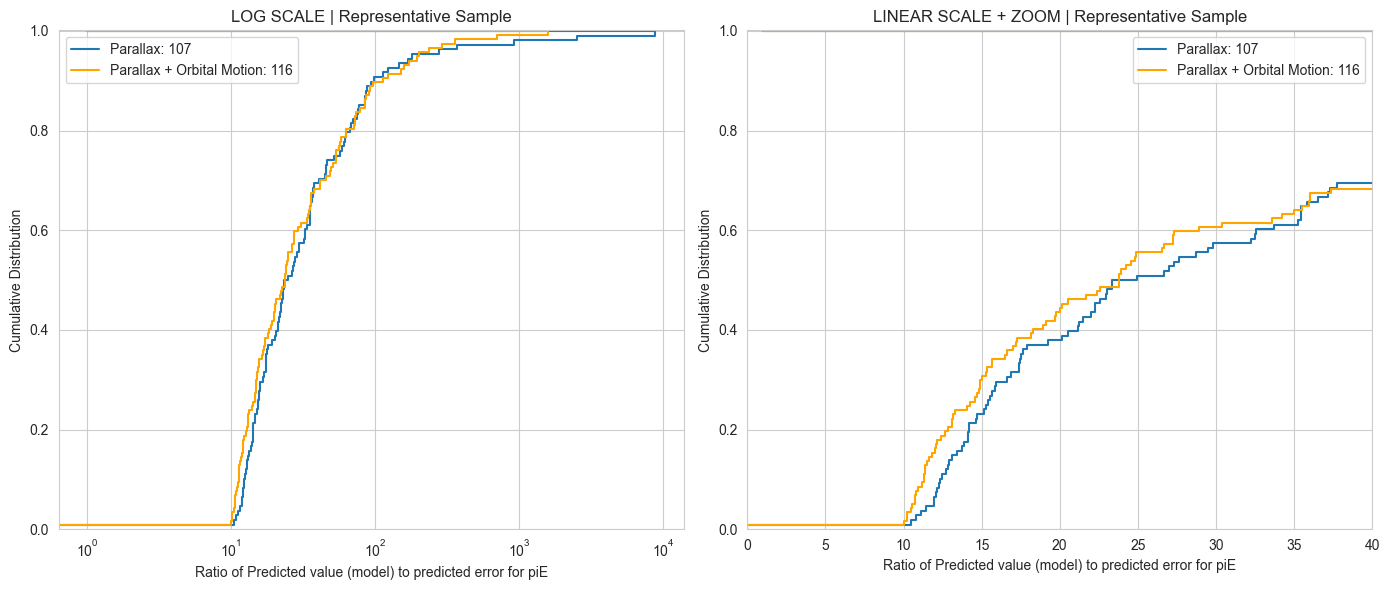

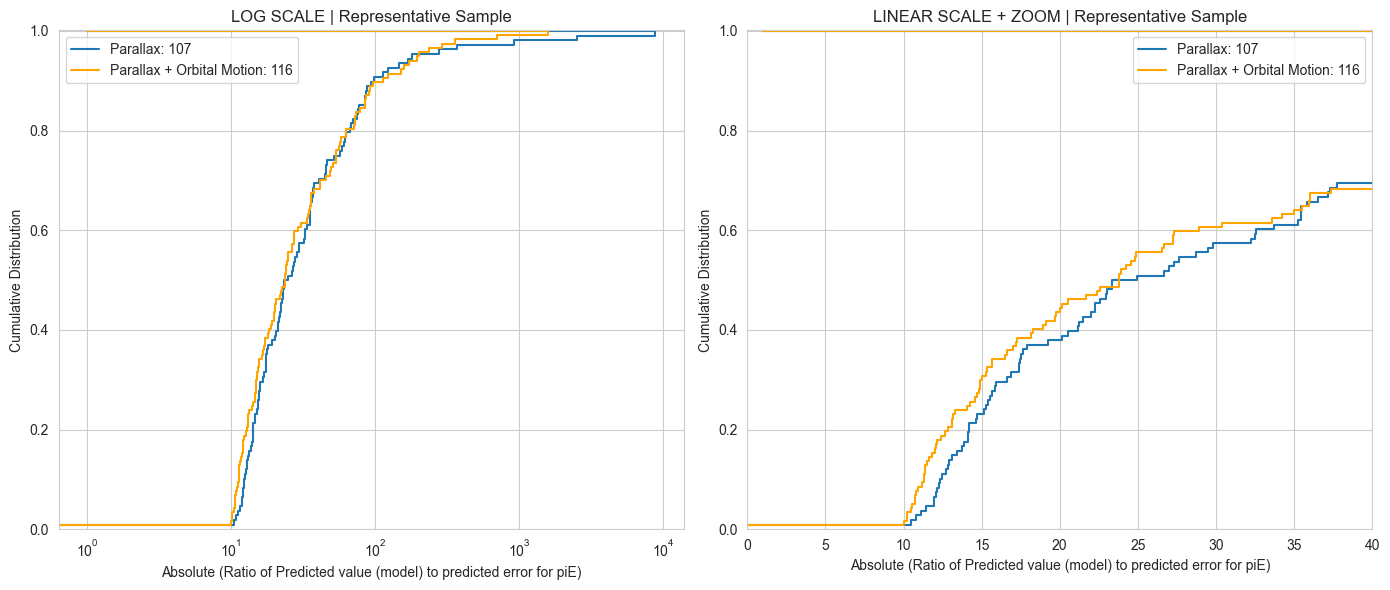

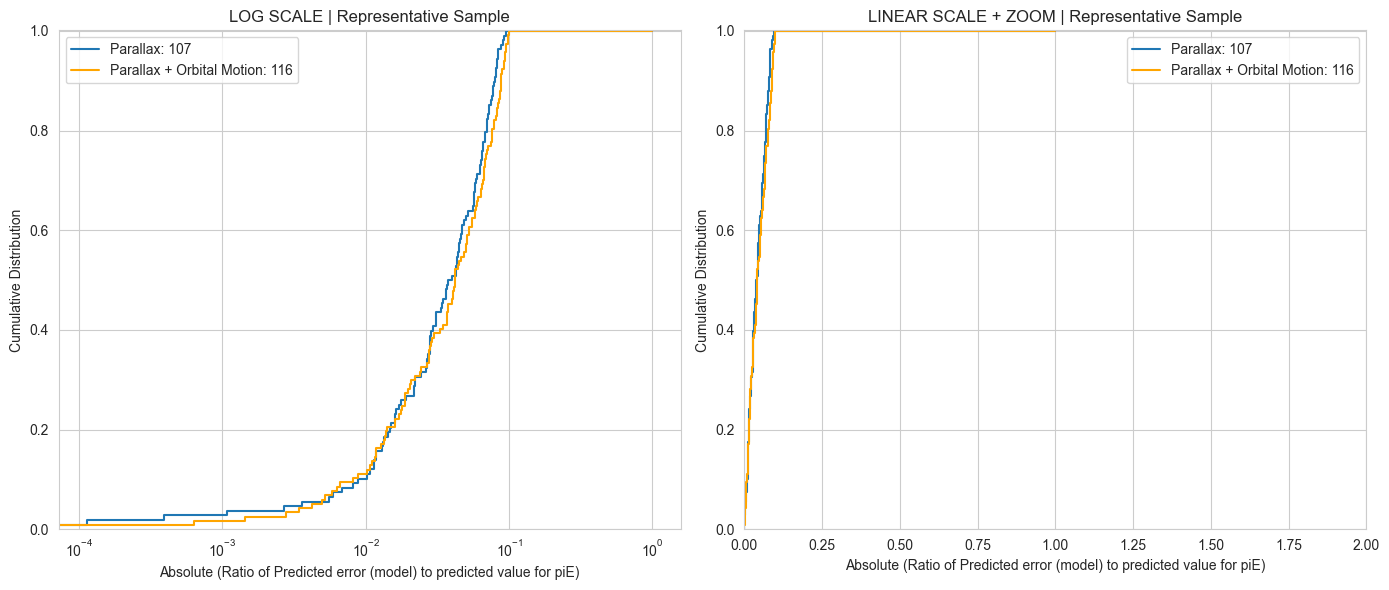

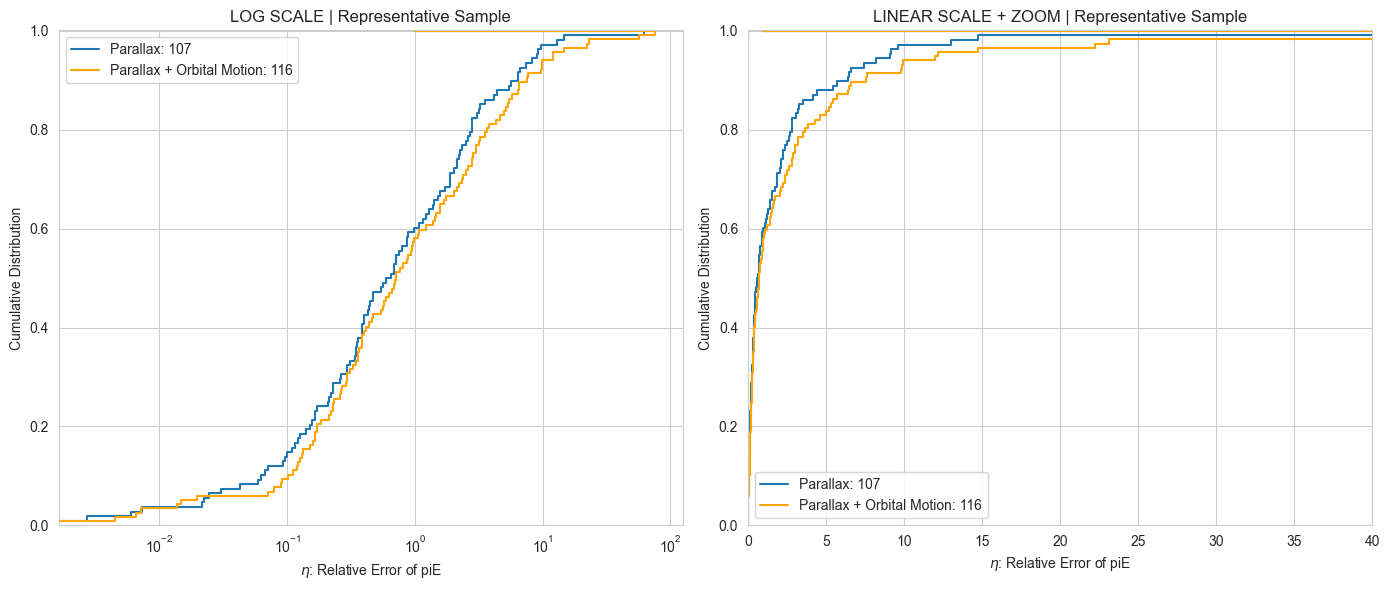

In [51]:
piE_type = 'piE'
cumulative_distribution_presentation_plotter(working_data_10_LX, f'LX_{piE_type}_absolute_standardized_residual', f'LO_{piE_type}_absolute_standardized_residual',
                                title='Representative Sample', what_you_plotting=f'Absolute Standardized Residual of {piE_type}',
                                             working_data_2_=working_data_10_LO)
cumulative_distribution_presentation_plotter(working_data_10_LX, f'LX_{piE_type}_predicted_value_predicted_error_ratio', f'LO_{piE_type}_predicted_value_predicted_error_ratio',
                                title='Representative Sample', what_you_plotting=f'Ratio of Predicted value (model) to predicted error for {piE_type}',
                                             working_data_2_=working_data_10_LO)
cumulative_distribution_presentation_plotter(working_data_10_LX, f'LX_{piE_type}_absolute_predicted_value_predicted_error_ratio', f'LO_{piE_type}_absolute_predicted_value_predicted_error_ratio',
                                title='Representative Sample', what_you_plotting=f'Absolute (Ratio of Predicted value (model) to predicted error for {piE_type})',
                                             working_data_2_=working_data_10_LO)
cumulative_distribution_presentation_plotter(working_data_10_LX, f'LX_{piE_type}_absolute_predicted_error_predicted_value_ratio', f'LO_{piE_type}_absolute_predicted_error_predicted_value_ratio',
                                title='Representative Sample', what_you_plotting=f'Absolute (Ratio of Predicted error (model) to predicted value for {piE_type})',
                                             working_data_2_=working_data_10_LO,
                                             xmax_linear=2)
cumulative_distribution_presentation_plotter(working_data_10_LX, f'LX_{piE_type}_relative_error', f'LO_{piE_type}_relative_error',
                                title='Representative Sample', what_you_plotting=fr'$\eta$: Relative Error of {piE_type}',
                                             working_data_2_=working_data_10_LO)

### piEE

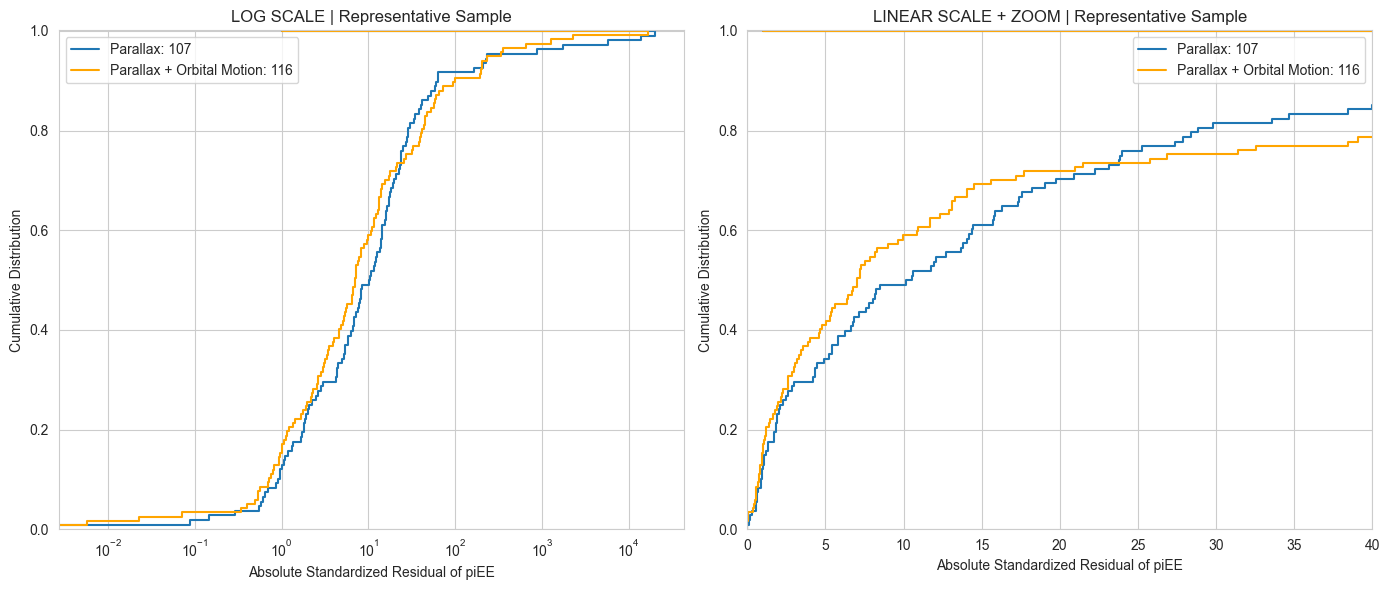

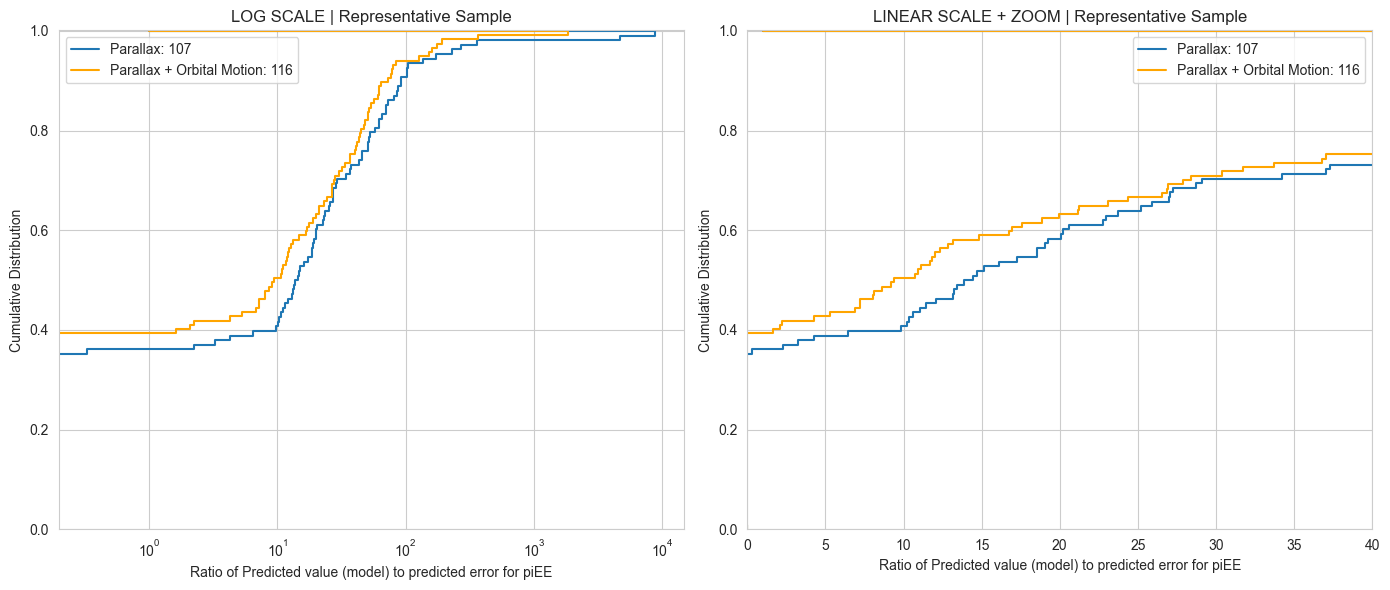

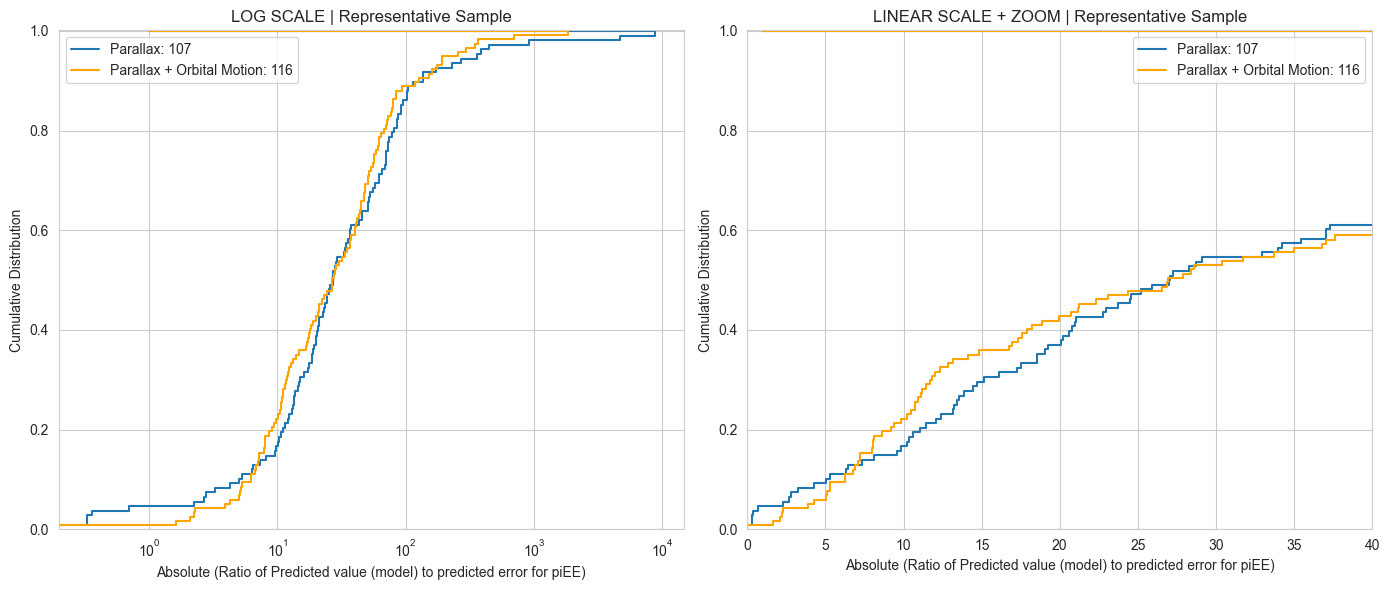

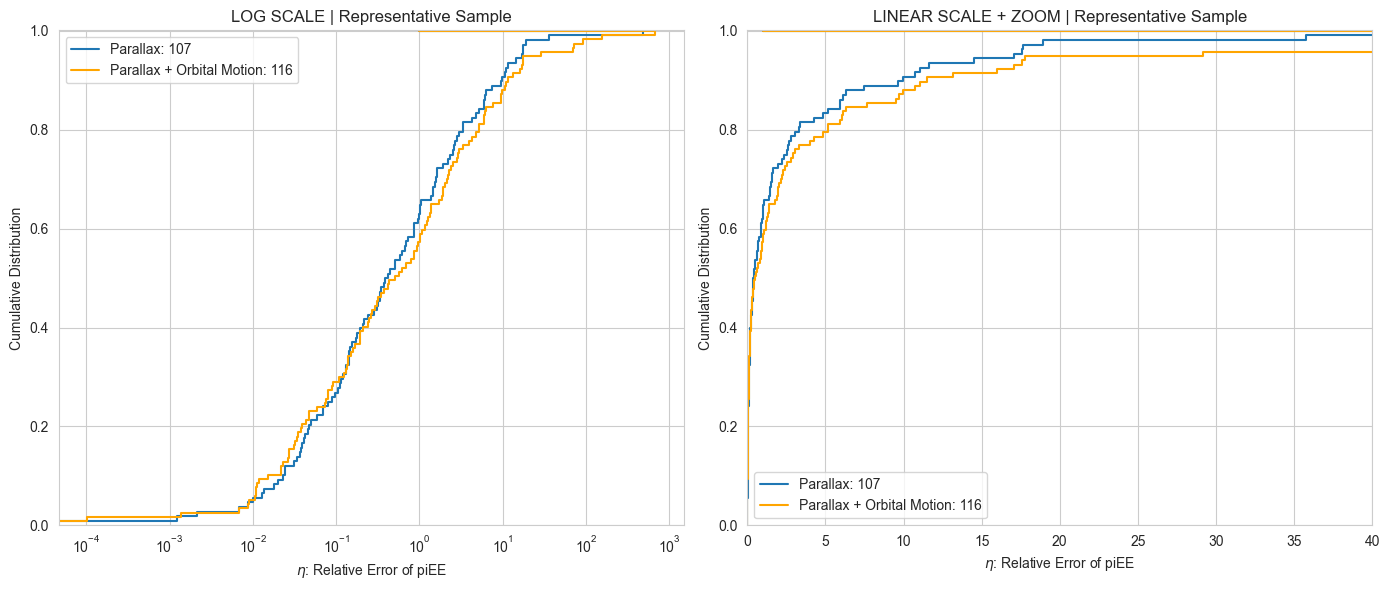

In [52]:
piE_type = 'piEE'
cumulative_distribution_presentation_plotter(working_data_10_LX, f'LX_{piE_type}_absolute_standardized_residual', f'LO_{piE_type}_absolute_standardized_residual',
                                title='Representative Sample', what_you_plotting=f'Absolute Standardized Residual of {piE_type}',
                                             working_data_2_=working_data_10_LO)
cumulative_distribution_presentation_plotter(working_data_10_LX, f'LX_{piE_type}_predicted_value_predicted_error_ratio', f'LO_{piE_type}_predicted_value_predicted_error_ratio',
                                title='Representative Sample', what_you_plotting=f'Ratio of Predicted value (model) to predicted error for {piE_type}',
                                             working_data_2_=working_data_10_LO)
cumulative_distribution_presentation_plotter(working_data_10_LX, f'LX_{piE_type}_absolute_predicted_value_predicted_error_ratio', f'LO_{piE_type}_absolute_predicted_value_predicted_error_ratio',
                                title='Representative Sample', what_you_plotting=f'Absolute (Ratio of Predicted value (model) to predicted error for {piE_type})',
                                             working_data_2_=working_data_10_LO)
cumulative_distribution_presentation_plotter(working_data_10_LX, f'LX_{piE_type}_relative_error', f'LO_{piE_type}_relative_error',
                                title='Representative Sample', what_you_plotting=fr'$\eta$: Relative Error of {piE_type}',
                                             working_data_2_=working_data_10_LO)

### piEN

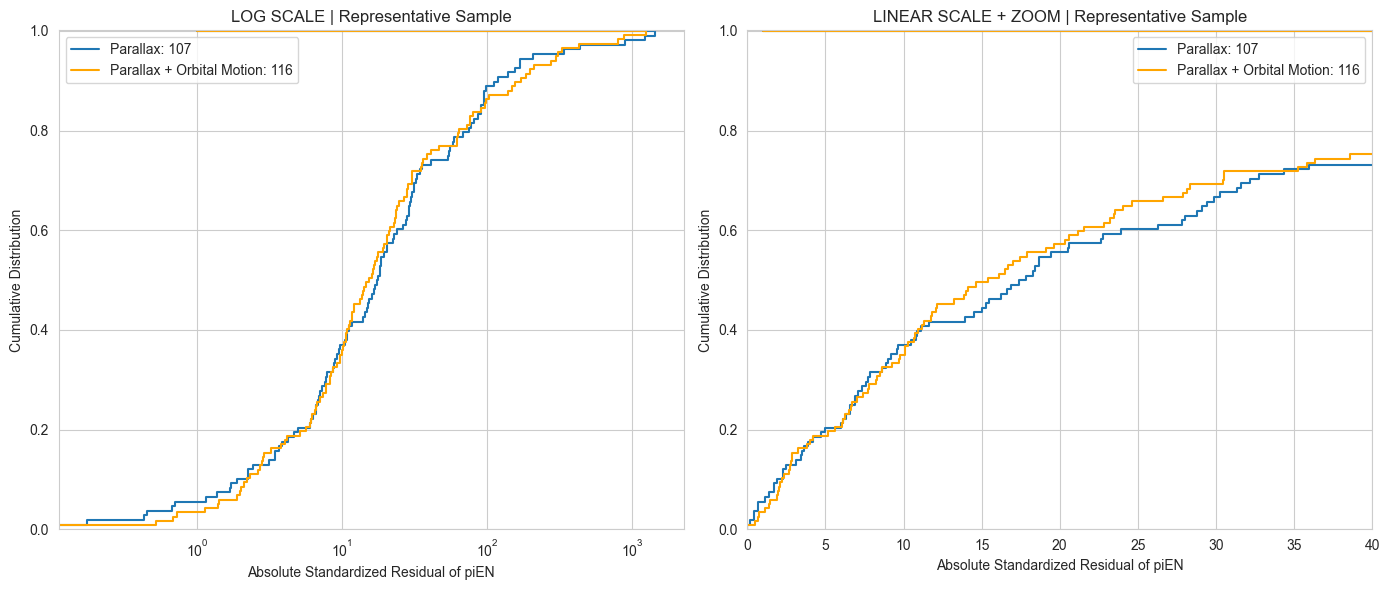

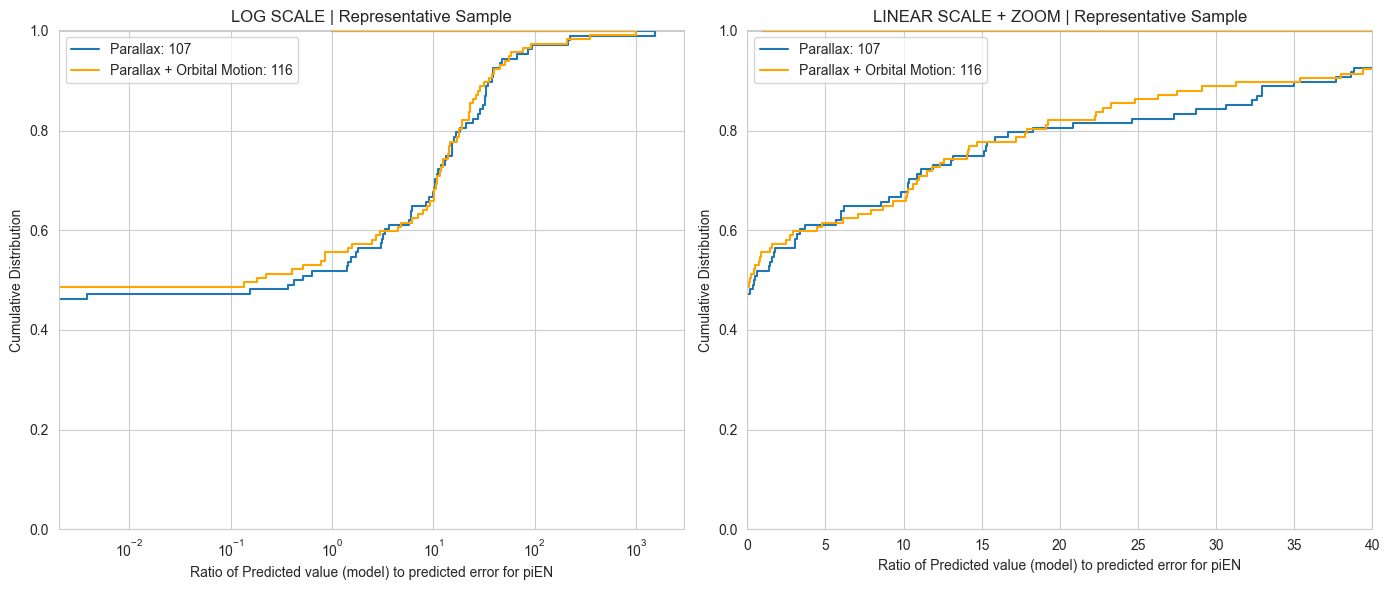

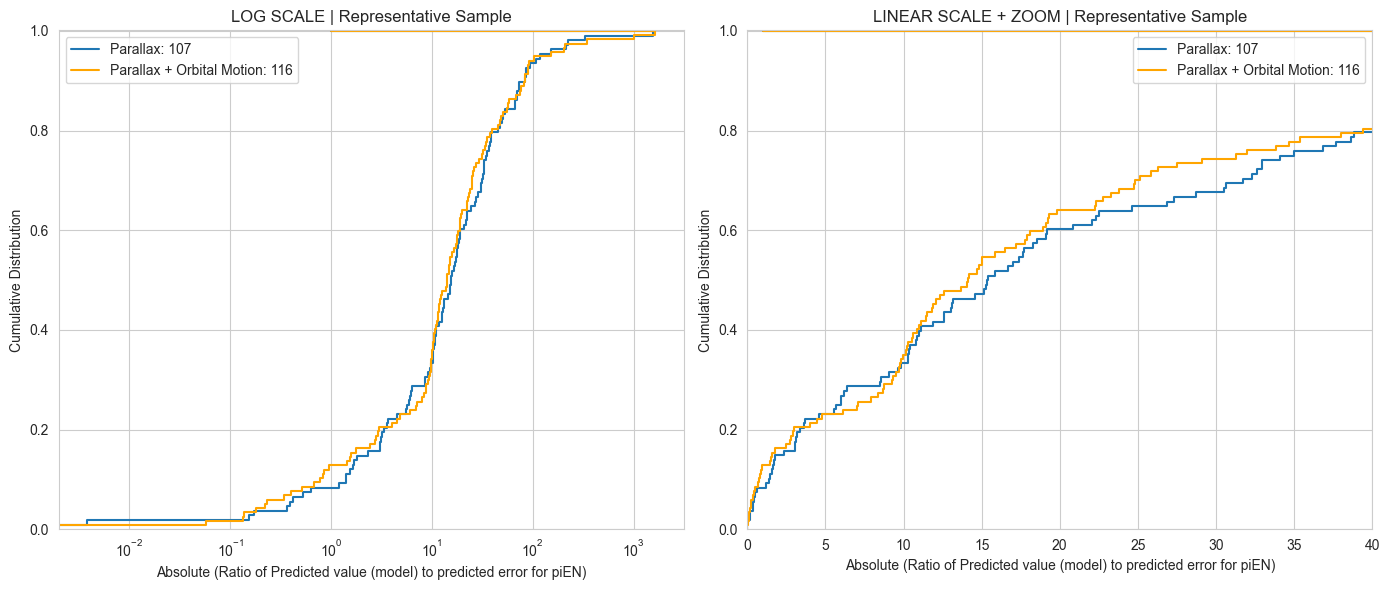

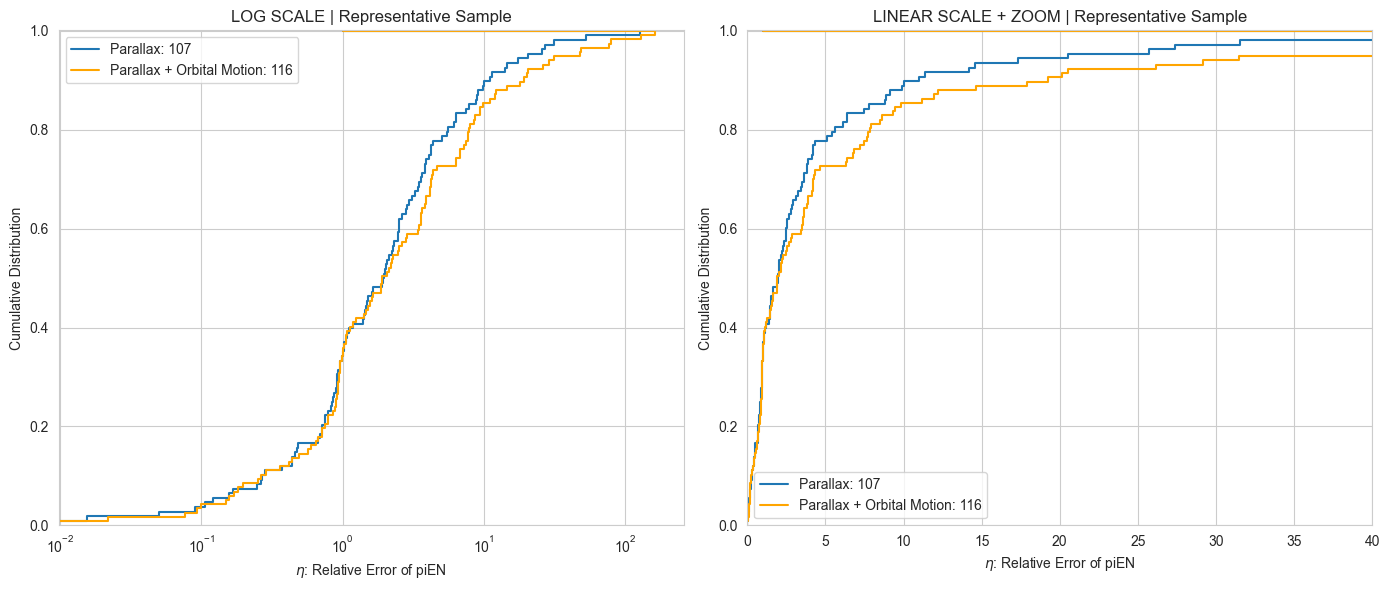

In [53]:
piE_type = 'piEN'
cumulative_distribution_presentation_plotter(working_data_10_LX, f'LX_{piE_type}_absolute_standardized_residual', f'LO_{piE_type}_absolute_standardized_residual',
                                title='Representative Sample', what_you_plotting=f'Absolute Standardized Residual of {piE_type}',
                                             working_data_2_=working_data_10_LO)
cumulative_distribution_presentation_plotter(working_data_10_LX, f'LX_{piE_type}_predicted_value_predicted_error_ratio', f'LO_{piE_type}_predicted_value_predicted_error_ratio',
                                title='Representative Sample', what_you_plotting=f'Ratio of Predicted value (model) to predicted error for {piE_type}',
                                             working_data_2_=working_data_10_LO)
cumulative_distribution_presentation_plotter(working_data_10_LX, f'LX_{piE_type}_absolute_predicted_value_predicted_error_ratio', f'LO_{piE_type}_absolute_predicted_value_predicted_error_ratio',
                                title='Representative Sample', what_you_plotting=f'Absolute (Ratio of Predicted value (model) to predicted error for {piE_type})',
                                             working_data_2_=working_data_10_LO)
cumulative_distribution_presentation_plotter(working_data_10_LX, f'LX_{piE_type}_relative_error', f'LO_{piE_type}_relative_error',
                                title='Representative Sample', what_you_plotting=fr'$\eta$: Relative Error of {piE_type}',
                                             working_data_2_=working_data_10_LO)

## Histograms

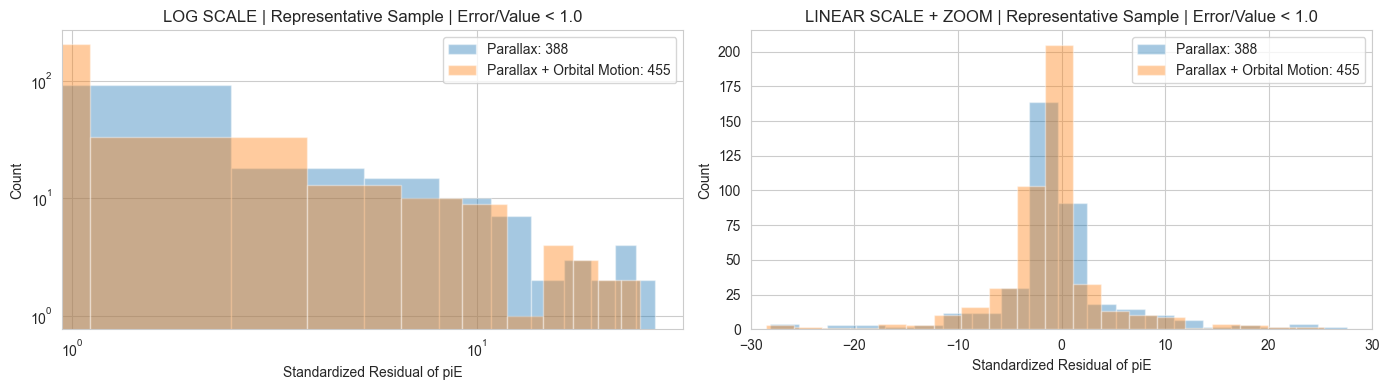

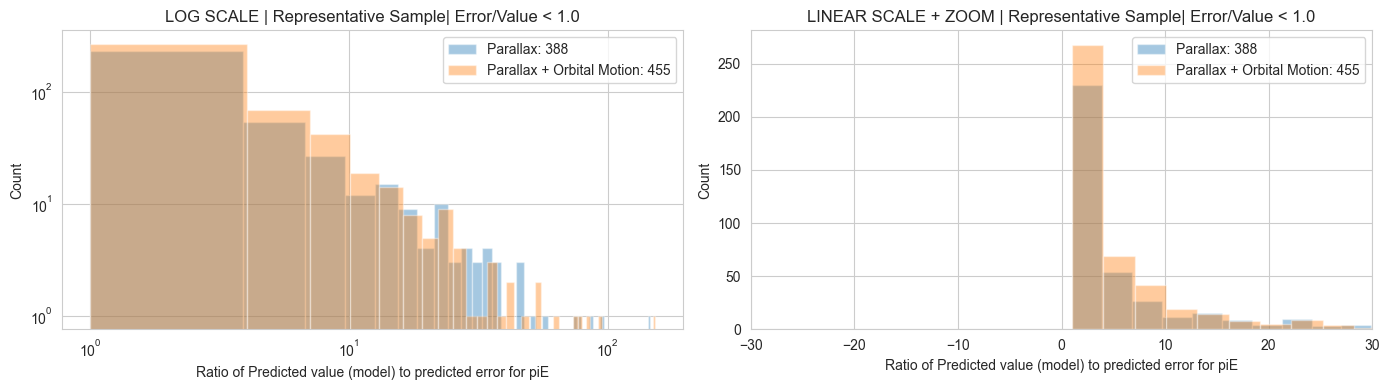

In [35]:
piE_type = 'piE'
working_data_dropped = working_data.loc[working_data[f'LX_{piE_type}_standardized_residual'] < 30]
working_data_dropped = working_data_dropped.loc[working_data_dropped[f'LX_{piE_type}_standardized_residual'] > -30]
working_data_dropped = working_data_dropped.loc[working_data_dropped[f'LO_{piE_type}_standardized_residual'] < 30]
working_data_dropped = working_data_dropped.loc[working_data_dropped[f'LO_{piE_type}_standardized_residual'] > -30]

working_data_10_LX = working_data_dropped[working_data_dropped[f'LX_{piE_type}_absolute_predicted_error_predicted_value_ratio'] < 1.0]
working_data_10_LO = working_data_dropped[working_data_dropped[f'LO_{piE_type}_absolute_predicted_error_predicted_value_ratio'] < 1.0]

histogram_presentation_plotter(working_data_10_LX, f'LX_{piE_type}_standardized_residual', f'LO_{piE_type}_standardized_residual',
                                title='Representative Sample | Error/Value < 1.0', what_you_plotting=f'Standardized Residual of {piE_type}', bins=20, working_data_2_=working_data_10_LO, xmax_linear=30)

histogram_presentation_plotter(working_data_10_LX, f'LX_{piE_type}_predicted_value_predicted_error_ratio', f'LO_{piE_type}_predicted_value_predicted_error_ratio',
                                title='Representative Sample| Error/Value < 1.0', what_you_plotting=f'Ratio of Predicted value (model) to predicted error for {piE_type}', bins=50, working_data_2_=working_data_10_LO, xmax_linear=30)

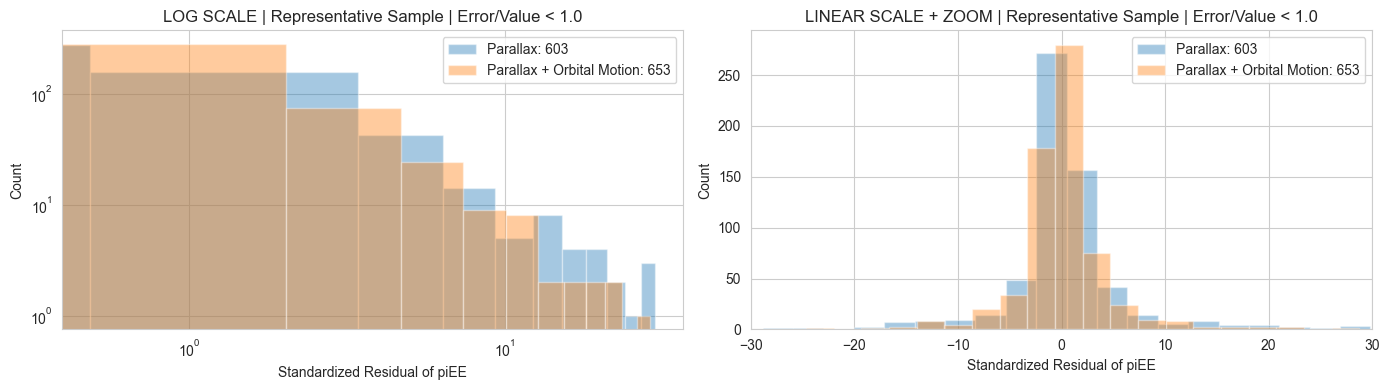

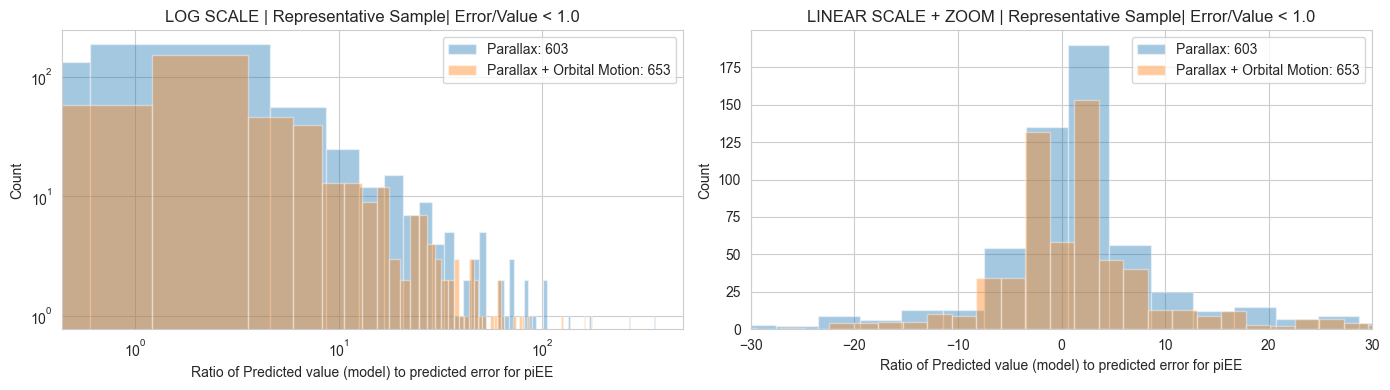

In [36]:
piE_type = 'piEE'
# working_data_dropped = working_data_.query("event_name != 'event_0_922_1199'")
working_data_dropped = working_data.loc[working_data[f'LX_{piE_type}_standardized_residual'] < 30]
working_data_dropped = working_data_dropped.loc[working_data_dropped[f'LX_{piE_type}_standardized_residual'] > -30]
working_data_dropped = working_data_dropped.loc[working_data_dropped[f'LO_{piE_type}_standardized_residual'] < 30]
working_data_dropped = working_data_dropped.loc[working_data_dropped[f'LO_{piE_type}_standardized_residual'] > -30]

working_data_10_LX = working_data_dropped[working_data_dropped[f'LX_{piE_type}_absolute_predicted_error_predicted_value_ratio'] < 1.0]
working_data_10_LO = working_data_dropped[working_data_dropped[f'LO_{piE_type}_absolute_predicted_error_predicted_value_ratio'] < 1.0]

histogram_presentation_plotter(working_data_10_LX, f'LX_{piE_type}_standardized_residual', f'LO_{piE_type}_standardized_residual',
                                title='Representative Sample | Error/Value < 1.0', what_you_plotting=f'Standardized Residual of {piE_type}', bins=20, working_data_2_=working_data_10_LO, xmax_linear=30)

histogram_presentation_plotter(working_data_10_LX, f'LX_{piE_type}_predicted_value_predicted_error_ratio', f'LO_{piE_type}_predicted_value_predicted_error_ratio',
                                title='Representative Sample| Error/Value < 1.0', what_you_plotting=f'Ratio of Predicted value (model) to predicted error for {piE_type}', bins=200, working_data_2_=working_data_10_LO, xmax_linear=30)

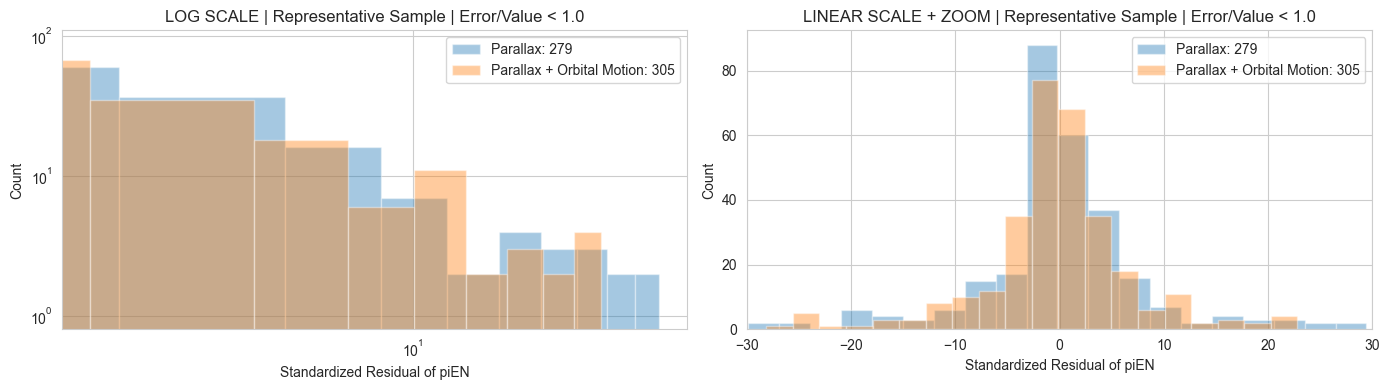

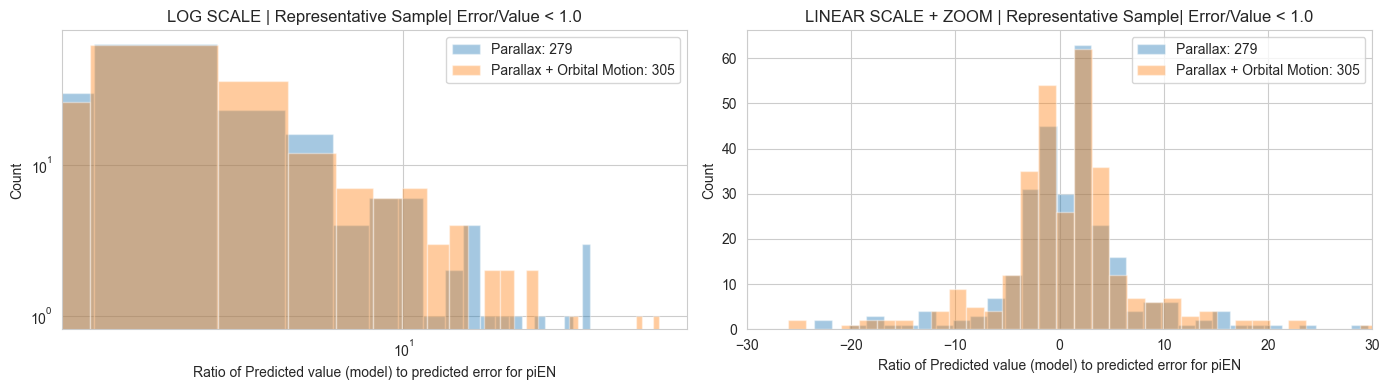

In [37]:
piE_type = 'piEN'
# working_data_dropped = working_data_.query("event_name != 'event_0_922_1199'")
working_data_dropped = working_data.loc[working_data[f'LX_{piE_type}_standardized_residual'] < 30]
working_data_dropped = working_data_dropped.loc[working_data_dropped[f'LX_{piE_type}_standardized_residual'] > -30]
working_data_dropped = working_data_dropped.loc[working_data_dropped[f'LO_{piE_type}_standardized_residual'] < 30]
working_data_dropped = working_data_dropped.loc[working_data_dropped[f'LO_{piE_type}_standardized_residual'] > -30]

working_data_10_LX = working_data_dropped[working_data_dropped[f'LX_{piE_type}_absolute_predicted_error_predicted_value_ratio'] < 1.0]
working_data_10_LO = working_data_dropped[working_data_dropped[f'LO_{piE_type}_absolute_predicted_error_predicted_value_ratio'] < 1.0]

histogram_presentation_plotter(working_data_10_LX, f'LX_{piE_type}_standardized_residual', f'LO_{piE_type}_standardized_residual',
                                title='Representative Sample | Error/Value < 1.0', what_you_plotting=f'Standardized Residual of {piE_type}', bins=20, working_data_2_=working_data_10_LO, xmax_linear=30)

histogram_presentation_plotter(working_data_10_LX, f'LX_{piE_type}_predicted_value_predicted_error_ratio', f'LO_{piE_type}_predicted_value_predicted_error_ratio',
                                title='Representative Sample| Error/Value < 1.0', what_you_plotting=f'Ratio of Predicted value (model) to predicted error for {piE_type}', bins=50, working_data_2_=working_data_10_LO, xmax_linear=30)